## Text Mining of the Product Reviews

### Preparation

#### Read in packages

In [884]:
import time
start = time.time()
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud.wordcloud import WordCloud, STOPWORDS
from PIL import Image
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
import gender_guesser.detector as gender
import warnings
warnings.filterwarnings("ignore")
from dask import compute, delayed
import dask.multiprocessing
import multiprocessing
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
import six
import statsmodels.api as sm
from sklearn.tree import export_graphviz
import graphviz
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
import yaml
import textstat
from scipy.stats import rankdata
import copy

sns.set(style="whitegrid")
plt.style.use('seaborn-deep')
plt.rc('text', usetex=True)

#pd.set_option('display.max_colwidth', 1)


#### Read in data

Sample product link:

https://www.amazon.com/Microsoft-Natural-Ergonomic-Keyboard-4000/dp/B000A6PPOK/ref=sr_1_3?dchild=1&keywords=Microsoft%2BNatural%2BErgonomic%2BKeyboard%2Bretail&qid=1585149060&sr=8-3&th=1#customerReviews

In [779]:
df = pd.read_csv("sample.csv")
df.drop('Unnamed: 0', axis = 1, inplace = True)
df.drop(['asin'], axis = 1, inplace = True)
df = df.rename(columns={'overall': 'Rating'})
df_original = copy.deepcopy(df)  
df.head(3)

,Rating,vote,verified,reviewTime,reviewerID,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,"1,113",True,"10 18, 2005",AILCWT1IIP7ZT,{'Style:': ' Retail'},Charles Chen,"As a software developer, I am literally attach...",Best Overall Keyboard to Date,1129593600,NaN
1,5.0,16,True,"10 12, 2005",A300T403J8526F,{'Style:': ' Retail'},T. Becker,"I've had a Natural Keyboard Pro for years, and...",Best keyboard I've used,1129075200,NaN
2,4.0,11,True,"10 5, 2005",AFPGV3IQ9K691,{'Style:': ' Retail'},GDC,"As with most Microsoft products, great hardwar...","Great keyboard, poor software.",1128470400,NaN


In [780]:
df_original['reviewText'].iloc[1]

"I've had a Natural Keyboard Pro for years, and now use it at work.  I was looking for a new home keyboard to replace the one from the MS Wireless Optical Desktop Comfort Edition (which is also a fine keyboard - if you're not a gamer; see the reviews for details).  While I liked the comfort curve keyboard, it wasn't a true ergonomic, and it gave me problems in gaming.  So when I saw that MS had redone the Natural Keyboard Pro, I jumped on it.  The reverse slope feels different at first but it isn't difficult to get used to at all.  The attachment does come off if you don't like it though.  The keyboard feels very well put together, typical of MS periphrials in my experience.\n\nI noticed that one user had complained about the software.  If you've used Intellitype before, don't expect anything new in version 5.3, which ships with this keyboard.  As far as I can tell, the only thing added was support for the new keyboards.  I have no major faults with it, although I've never owned a Logi

In [781]:
df.iloc[1]

Rating                                                            5
vote                                                             16
verified                                                       True
reviewTime                                              10 12, 2005
reviewerID                                           A300T403J8526F
style                                         {'Style:': ' Retail'}
reviewerName                                              T. Becker
reviewText        I've had a Natural Keyboard Pro for years, and...
summary                                     Best keyboard I've used
unixReviewTime                                           1129075200
image                                                           NaN
Name: 1, dtype: object

In [782]:
df['unixReviewTime'].min(), df['unixReviewTime'].max()

(1128470400, 1526688000)

In [783]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2567 entries, 0 to 2566
Data columns (total 11 columns):
Rating            2567 non-null float64
vote              174 non-null object
verified          2567 non-null bool
reviewTime        2567 non-null object
reviewerID        2567 non-null object
style             2554 non-null object
reviewerName      2567 non-null object
reviewText        2567 non-null object
summary           2567 non-null object
unixReviewTime    2567 non-null int64
image             13 non-null object
dtypes: bool(1), float64(1), int64(1), object(8)
memory usage: 203.2+ KB


#### Word Cloud

In [995]:
WORDS=[]
for i in range(df_original.shape[0]):
    words=df_original["reviewText"].astype('str').iloc[i].split(";")
    for word in words:
        WORDS.append(word)

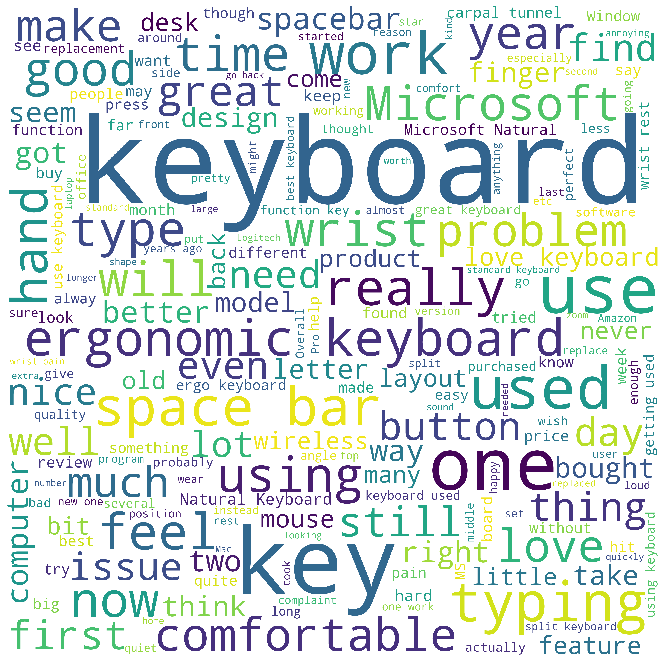

In [997]:
wc = WordCloud(stopwords=STOPWORDS,background_color='white',
               width=5000,height=5000).generate(" ".join(set(WORDS)))
plt.figure(figsize = (20,12))
plt.imshow(wc)
#plt.title("Word Cloud Visualization of Sample Reviews")
plt.axis('off')
plt.savefig("plots/tagswordcloud.png")

#### Text cleaning & pre-processing

__Tokenization__: Split the text into sentences and the sentences into words. 

__Lowercase__ the words and __remove punctuation__.

Words that have fewer than 3 characters are removed.

All __stopwords__ are removed.

Words are __lemmatized__: words in third person are changed to first person and verbs in past and future tenses are changed into present.

Words are __stemmed__: words are reduced to their root form.

Reference: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

In [784]:
np.random.seed(2020)

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, SnowballStemmer
stemmer = SnowballStemmer("english")
from nltk.stem.porter import *

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint

import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim 

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lliu9\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


##### Preprocess the data

In [785]:
def compute_corpus(data):
    
    #Functions to perform lemmatize and stem preprocessing steps
    def lemmatize_stemming(text):
        return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

    def preprocess(text):
        result = []
        for token in gensim.utils.simple_preprocess(text):
            if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
                result.append(lemmatize_stemming(token))
        return result

    processed_docs = data.map(preprocess)
    #Bag of words & Filter out infrequent tokens
    dictionary = gensim.corpora.Dictionary(processed_docs)
    dictionary.filter_extremes(no_below = 10, no_above = 0.5, keep_n = 10000)

    #count = 0
    #for k, v in dictionary.iteritems():
    #    print(k, v)
    #    count += 1
    #    if count > 10:
    #        break
    
    #doc2bow: how many words and how many times those words appear in one document
    
    bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
    
    #bow_corpus[10]
    #bow_doc = bow_corpus[10]
    #for i in range(len(bow_doc)):
    #    print("Word {} (\"{}\") appears {} time.".format(bow_doc[i][0], dictionary[bow_doc[i][0]], bow_doc[i][1]))
        
    #TF-IDF (frequency-inverse document frequency): how important a word is to a document in a collection or corpus
    tfidf = models.TfidfModel(bow_corpus)
    corpus = tfidf[bow_corpus]
    #for doc in corpus:
    #    pprint(doc)
    #    break
    return processed_docs, corpus, dictionary

### Features: Latent Topics

In [786]:
#Full data
processed_docs, corpus, dictionary = compute_corpus(df_original['reviewText'])

#Split data
review_train, review_test = train_test_split(df_original['reviewText'], random_state = 10, test_size = 0.3)
processed_docs_train, corpus_train, dictionary_train = compute_corpus(review_train)
processed_docs_test, corpus_test, dictionary_test = compute_corpus(review_test)

### Optimal number of topics for LDA 

In [787]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    log_perplexity_values: log prplexity values to the LDA model with respective number of topics
    """
    
    coherence_values = []
    log_perplexity_values = []
    model_list = []
    
    #Iterate through different number of topics
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                                num_topics=num_topics, 
                                                id2word=dictionary, 
                                                random_state=10,
                                                chunksize = 100,
                                                passes = 10,
                                                alpha = 'auto',       
                                                per_word_topics = True)
        
        model_list.append(model)
        
        #Compute Coherence Score
        coherencemodel = CoherenceModel(model=model, 
                                        texts=texts, 
                                        dictionary=dictionary, 
                                        coherence='c_v')
        
        
        coherence_values.append(coherencemodel.get_coherence())
        
        #Compute Perplexity
        log_perplexity_values.append(model.log_perplexity(corpus))

    return model_list, coherence_values, log_perplexity_values

In [788]:
#comment out as execution takes a while

limit = 8; start = 2; step = 1;

model_list, coherence_values, log_perplexity = compute_coherence_values(dictionary=dictionary_test,
                                                                        corpus=corpus_test, 
                                                                        texts=processed_docs_test, 
                                                                        start=start, 
                                                                        limit=limit, 
                                                                        step=step)

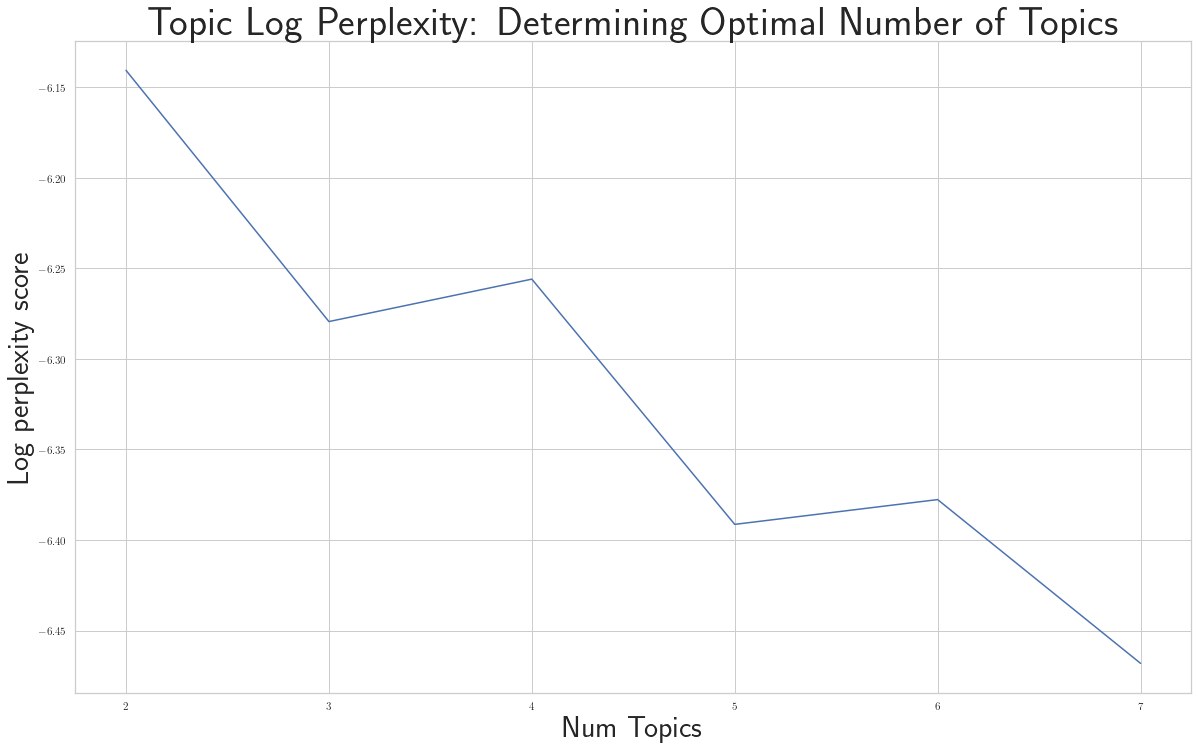

In [789]:
x = np.arange(start, limit, step)
plt.figure(figsize = (20,12))
plt.plot(x, log_perplexity)
plt.xlabel("Num Topics", fontsize=30)
plt.ylabel("Log perplexity score", fontsize=30)
plt.title('Topic Log Perplexity: Determining Optimal Number of Topics', fontsize=40)
plt.savefig("Plots/perplexity.png")

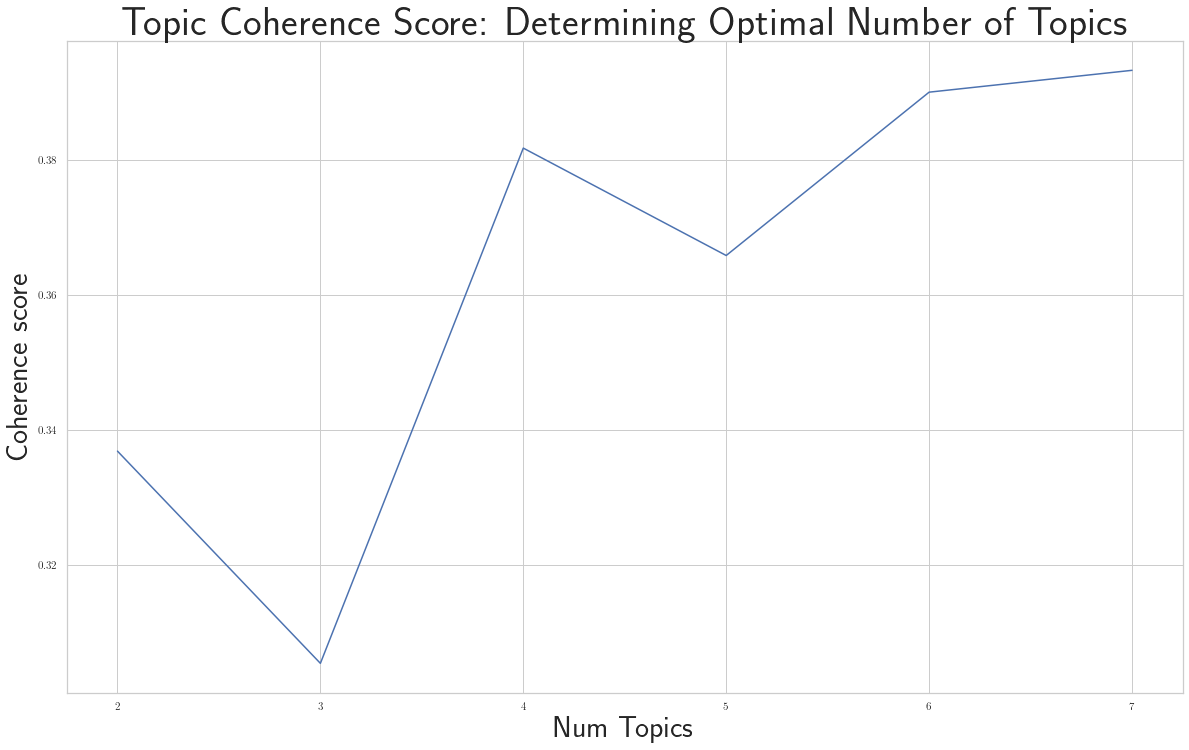

In [790]:
x = np.arange(start, limit, step)
plt.figure(figsize = (20,12))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics", fontsize=30)
plt.ylabel("Coherence score", fontsize=30)
plt.title('Topic Coherence Score: Determining Optimal Number of Topics', fontsize=40)
plt.savefig("Plots/coherence.png")

In [791]:
opt_topics = np.argmax(coherence_values) + start
opt_topics

7

##### Topic proportions as features

In [792]:
opt_topics = 4

lda_model_opt = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                             id2word = dictionary,
                                            num_topics = opt_topics, 
                                           random_state = 100,
                                           chunksize = 100,
                                           passes = 10,
                                           alpha = 'auto',       
                                           per_word_topics = True)

In [793]:
props = []
for ind in range(len(corpus)):
    props.append([i[1].round(10) for i in lda_model_opt.get_document_topics(corpus[ind])])

#### Topics Visualization

In [794]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_opt, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.276404  0.169440       1        1  43.011135
3     -0.063533 -0.313676       2        1  35.300804
2      0.209789  0.102118       3        1  11.342685
0      0.130149  0.042119       4        1  10.345379, topic_info=    Category       Freq    Term      Total  loglift  logprob
71   Default  45.000000    love  45.000000  30.0000  30.0000
393  Default  28.000000    mous  28.000000  29.0000  29.0000
48   Default  54.000000    good  54.000000  28.0000  28.0000
162  Default  51.000000    year  51.000000  27.0000  27.0000
139  Default  21.000000   stiff  21.000000  26.0000  26.0000
..       ...        ...     ...        ...      ...      ...
404   Topic4   9.471203    tire  10.109731   2.2034  -4.6231
403   Topic4   9.342164  regist   9.978273   2.2028  -4.6368
413   Topic4   8.916311    care   9.523923   2.2027  -4.6835
71    Topic4  42.935467    love  45.913872   2.2016  -3.1116
722   Topic4   9.346683     eas  10.025307   2.1985  -4.6363

[172 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
373       2  0.180887  action
373       3  0.813991  action
1         3  0.983876  actual
3         4  0.989696  adjust
9         1  0.980081    best
...     ...       ...     ...
160       2  0.431700    work
161       1  0.203922   wrist
161       2  0.797151   wrist
162       2  0.994553    year
163       1  0.984432    zoom

[158 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1])

Topic 1: functionality (work, type, time, wrist, space)
    
Topic 2: user experience (key, like, button, feel, design)

Topic 3: brand and product name (microsoft, nature, comfort, ergonomic, good)

Topic 4: feelings (great, best, spacebar, product, space)

Topic 5: compatibility (mouse, board, perfect, driver, experience)
    

In [795]:
#Append topic proportions to the dataframe
topic_names = []
for i in range(1,opt_topics+1): 
    topic_name = "Topic"+str(i)
    topic_names.append(topic_name)
    df[topic_name] = [prop[i-1] for prop in props]

In [796]:
df_original.iloc[10]['reviewText']

"Absolutely love this keyboard.  I had an older one and the letters were worn off.  Didn't bother me, but my wife was very pleased when she saw that it had the letters still on the keys.  This keyboard feels great and is just designed so well."

In [797]:
df.iloc[10]

Rating                                                            5
vote                                                            NaN
verified                                                       True
reviewTime                                               05 2, 2018
reviewerID                                            AL2K9U4ALBKQP
style                                       {'Style:': ' Business'}
reviewerName                                               J. Giles
reviewText        Absolutely love this keyboard.  I had an older...
summary                   Love this keyboard. Well worth the money.
unixReviewTime                                           1525219200
image                                                           NaN
Topic1                                                     0.105258
Topic2                                                     0.421703
Topic3                                                     0.110148
Topic4                                          

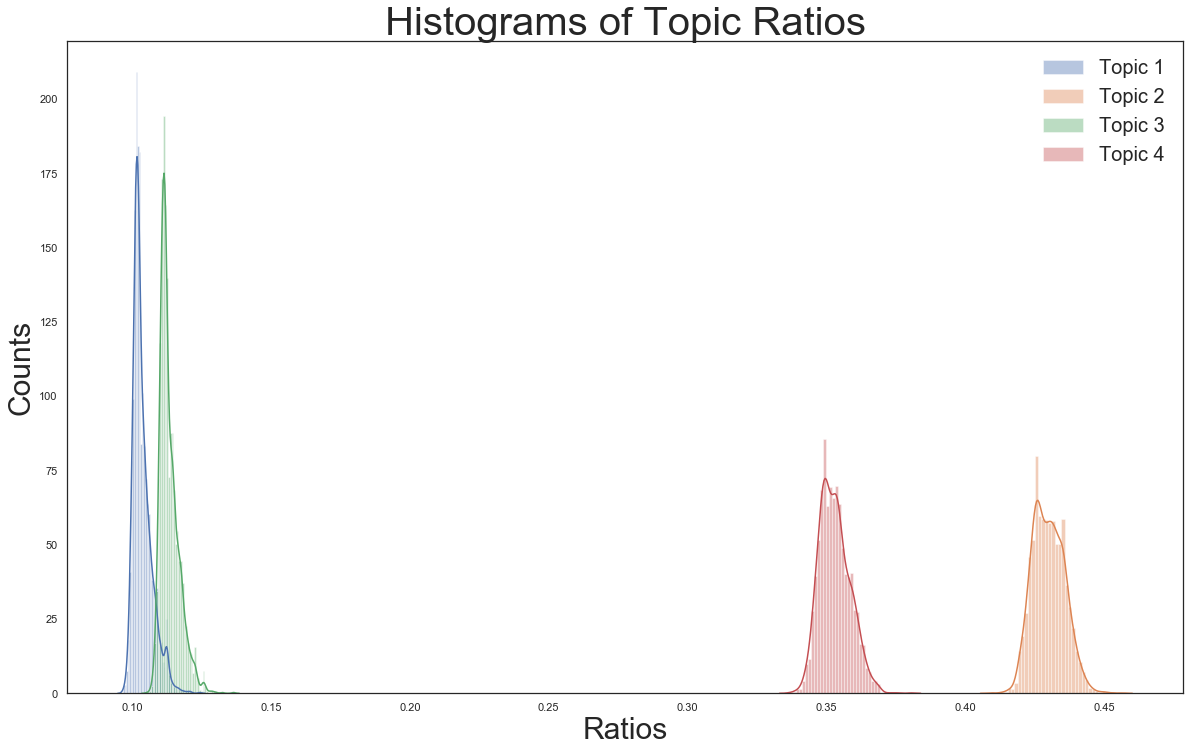

In [1063]:
plt.figure(figsize = (20,12))
plt.title('Histograms of Topic Ratios', fontsize=40)
sns.distplot(df['Topic1'], label="Topic 1")
sns.distplot(df['Topic2'], label="Topic 2")
sns.distplot(df['Topic3'], label="Topic 3")
sns.distplot(df['Topic4'], label="Topic 4")
plt.legend(numpoints=10, frameon=False, fontsize=20)
plt.xlabel('Ratios', fontsize=30)
plt.ylabel('Counts', fontsize=30)
plt.savefig('Plots/Histograms of Topic Ratios.png')

### Features engineering

#### Get the number of associated images

In [798]:
def imagenum(df):
    """
    Outputs the number of images from the `image` column
    """
    if type(df['image']) == float:
        return 0
    else:
        return len(df['image'])

df['Image Number'] = df.apply(imagenum, axis=1)

In [799]:
# % of reviews don't have images
len(df[df['Image Number']==0])/df.shape[0]

0.9949357226334242

#### Get the indicator of being verified or not

In [800]:
def verified(df):
    """
    Outputs the indicator (1/0) from the `verified` column
    """
    if df['verified'] == True:
        return 1
    else:
        return 0
    
df['Verified Purchase'] = df.apply(verified, axis=1)

In [801]:
df['verified'].value_counts()
df['verified'].value_counts()/df.shape[0]

True     0.862875
False    0.137125
Name: verified, dtype: float64

In [802]:
# Verified reviews have higher average scores
df.groupby(['verified']).mean()['Rating']

verified
False    3.593750
True     4.303837
Name: Rating, dtype: float64

#### Get the indicator of using a real name

One tried approach: named entities extraction

Pbm: cannot tell the real or seemingly-real names

https://towardsdatascience.com/custom-named-entity-recognition-using-spacy-7140ebbb3718

https://spacy.io/usage/linguistic-features#named-entities

Approach: return true if the `revierName` has verfied first names by gender guesser (not unknown in the name database), (middle name), and last name 

https://pypi.org/project/gender-guesser/

In [803]:
def nameverified(df):
    """
    Output the indicator (1/0) from the `reviewerName` column 
    """
    try:
        parts = df['reviewerName'].split(' ')
        if len(parts) >= 2:
            if gender.Detector().get_gender(parts[0]) != 'unknown': 
                return 1
        else:
            return 0
    except AttributeError:
        return 0

df['Verified Name'] = df.apply(nameverified, axis=1)
df['Verified Name'] = df['Verified Name'].fillna(0)

In [804]:
df['Verified Name'].value_counts()

0.0    1744
1.0     823
Name: Verified Name, dtype: int64

#### Sentiment

In [805]:
def sentiment(df):
    """
    Outputs the sentiment score for each review
    """
    return analyser.polarity_scores(df['reviewText'])['compound']

df['Sentiment'] = df.apply(sentiment, axis=1)

In [806]:
# Sentiment scores are positively correlated with the overall rating, but the correlation is not strong
round(np.corrcoef(df['Rating'],  df["Sentiment"])[0,1],3)

0.376

In [807]:
df['Sentiment'].describe()

count    2567.000000
mean        0.454418
std         0.539726
min        -0.994900
25%         0.144700
50%         0.636900
75%         0.877700
max         0.999500
Name: Sentiment, dtype: float64

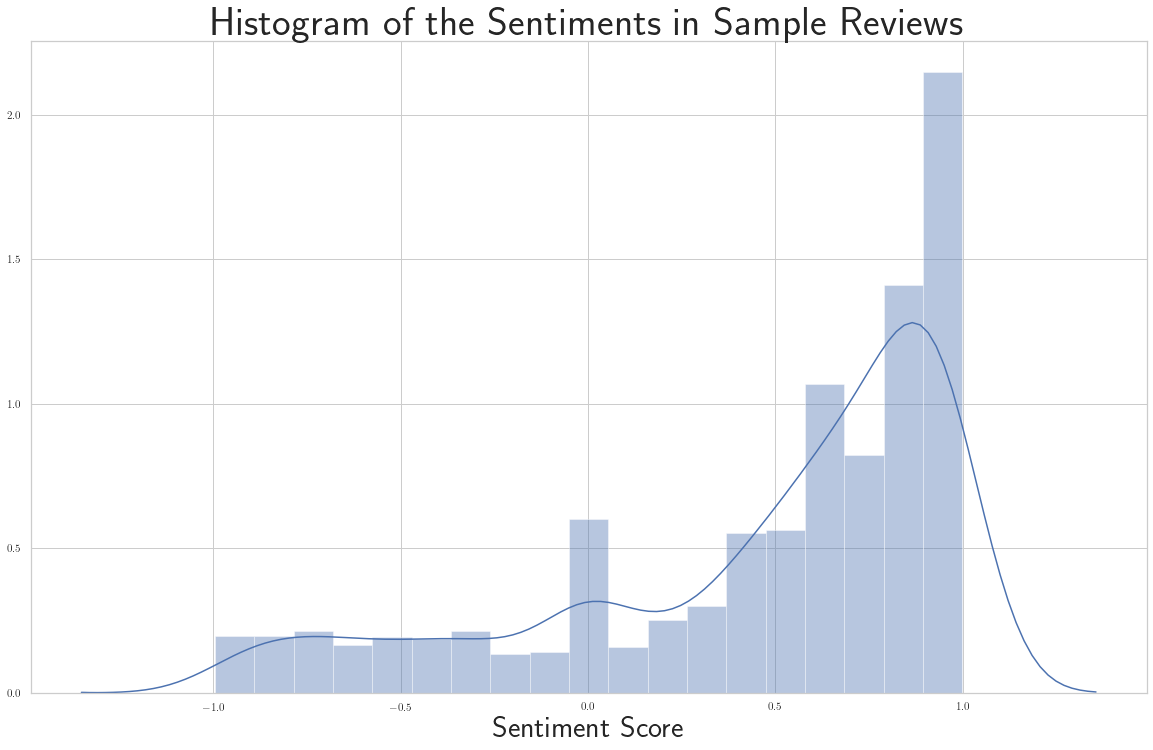

In [808]:
plt.figure(figsize = (20,12))
sns.distplot(df['Sentiment'])
plt.xlabel("Sentiment Score", fontsize=30)
plt.title("Histogram of the Sentiments in Sample Reviews", fontsize=40)
plt.savefig('Plots/Sentiments.png')

<Figure size 1440x2160 with 0 Axes>

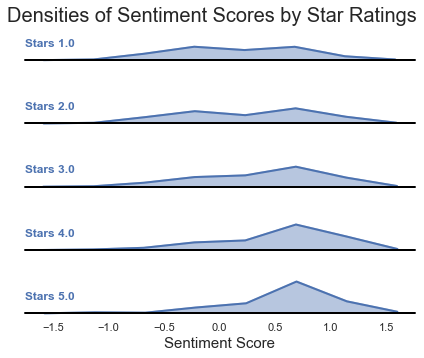

In [917]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
plt.figure(figsize = (20,30))

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.8)
g = sns.FacetGrid(df, row="Rating", hue="Rating", aspect=6, height=1, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Sentiment", clip_on=False, shade=True, color="b", gridsize=8, alpha=0.4, lw=2, bw=.2)
g.map(sns.kdeplot, "Sentiment", clip_on=False, color="b", gridsize=8,  lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, color="black", clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .5, "Stars "+label, fontweight="bold", color="b",
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "Rating")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=0.9)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.suptitle('Densities of Sentiment Scores by Star Ratings', fontsize=20)
plt.xlabel('Sentiment Score', fontsize=15)
plt.savefig('Plots/Densities of Sentiment Scores by Star Ratings.png')

#### Length

https://pypi.org/project/textstat/

In [810]:
def length(df):
    """
    Output the lexicon counts for each review
    """
    return textstat.lexicon_count(df['reviewText'], removepunct = True)

df['Review Length'] = df.apply(length, axis=1)

In [811]:
df['Review Length'].describe()

count    2567.000000
mean       81.370861
std       103.028761
min         0.000000
25%        20.000000
50%        49.000000
75%       102.000000
max      1179.000000
Name: Review Length, dtype: float64

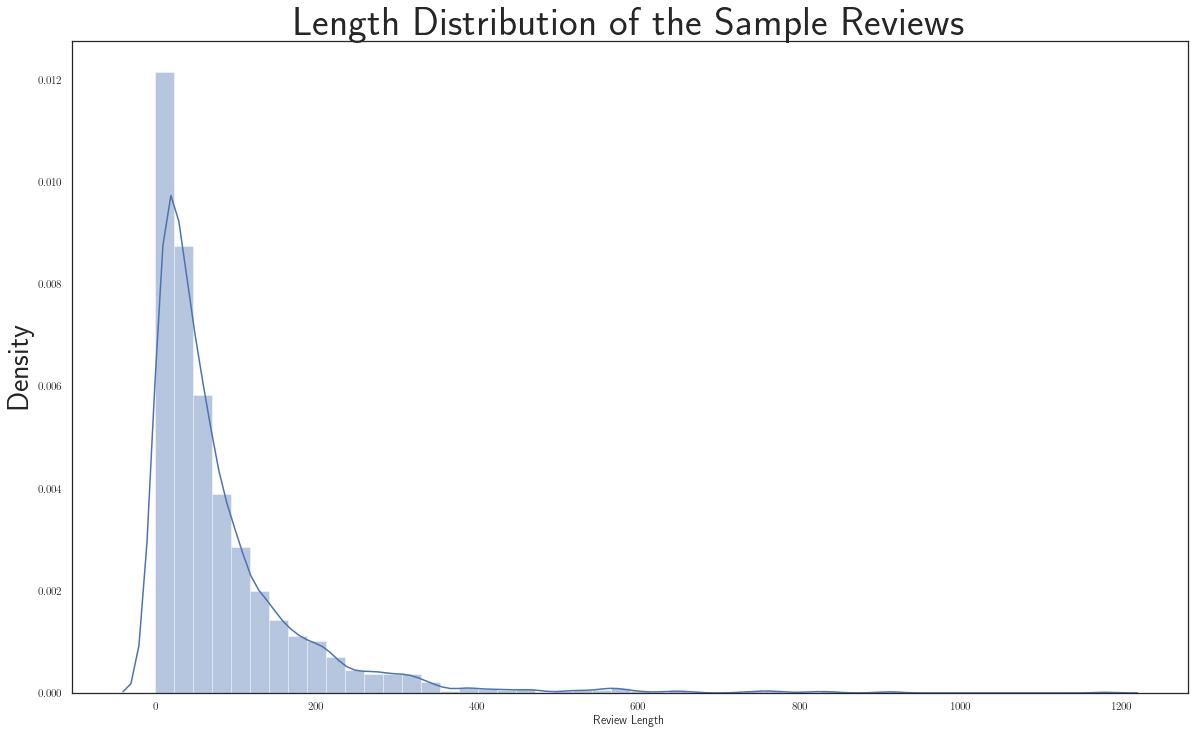

In [812]:
plt.figure(figsize=(20,12))
sns.distplot(df['Review Length'])
plt.ylabel('Density', fontsize=30)
plt.title('Length Distribution of the Sample Reviews', fontsize=40)
plt.savefig('Plots/Length Distribution of the Sample Reviews')

#### Digits count

In [813]:
df['Digits Count'] = df_original['reviewText'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

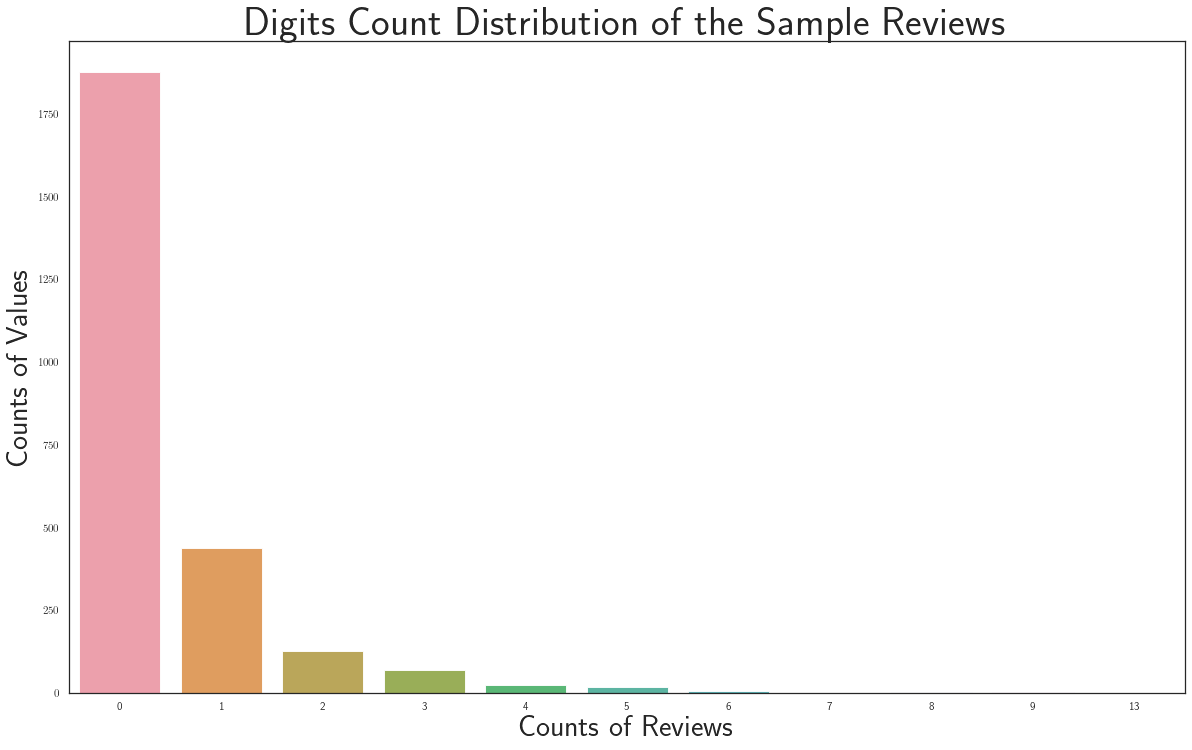

In [814]:
sns.set_color_codes("muted")
df['Digits Count'].value_counts().index
Digits = pd.DataFrame({'Index':df['Digits Count'].value_counts().index, 'Values':df['Digits Count'].value_counts().values})
plt.figure(figsize=(20,12))
sns.barplot( x="Index", y="Values", data = Digits, alpha=0.9)
plt.ylabel('Counts of Values', fontsize=30)
plt.xlabel('Counts of Reviews', fontsize=30)
plt.xticks(rotation=0)
plt.title('Digits Count Distribution of the Sample Reviews', fontsize=40)
plt.savefig('Plots/Digits Counts Distribution of the Sample Reviews.png')

#### Flesch reading ease score

In [815]:
def flesch(df):
    """
    Output the Flesch reading ease score for each review
    """
    return textstat.flesch_reading_ease(df['reviewText'])

df['Readability Score'] = df.apply(flesch, axis=1)

In [816]:
df['Readability Score'].describe()

count    2567.000000
mean       54.324063
std        65.756029
min     -1108.300000
25%        46.440000
50%        71.480000
75%        83.660000
max       206.840000
Name: Readability Score, dtype: float64

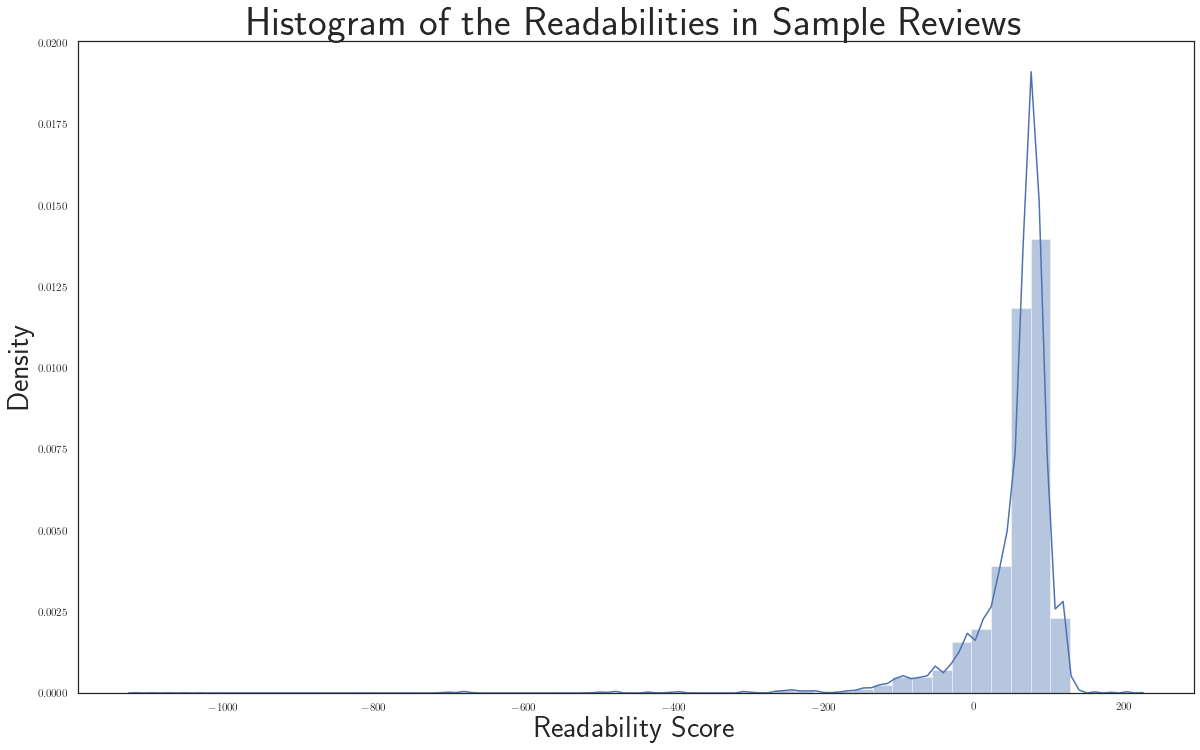

In [817]:
plt.figure(figsize = (20,12))
sns.distplot(df['Readability Score'])
plt.xlabel('Readability Score', fontsize=30)
plt.ylabel('Density', fontsize=30)
plt.title("Histogram of the Readabilities in Sample Reviews", fontsize=40)
plt.savefig('Plots/readability.png')

#### Length of Summary

In [818]:
def summary_length(df):
    """
    Output the length for each review summary
    """
    return textstat.lexicon_count(df['summary'], removepunct = True)

df['Summary Length'] = df.apply(summary_length, axis=1)

In [819]:
df['Summary Length'].describe()

count    2567.000000
mean        5.081808
std         3.697275
min         1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        28.000000
Name: Summary Length, dtype: float64

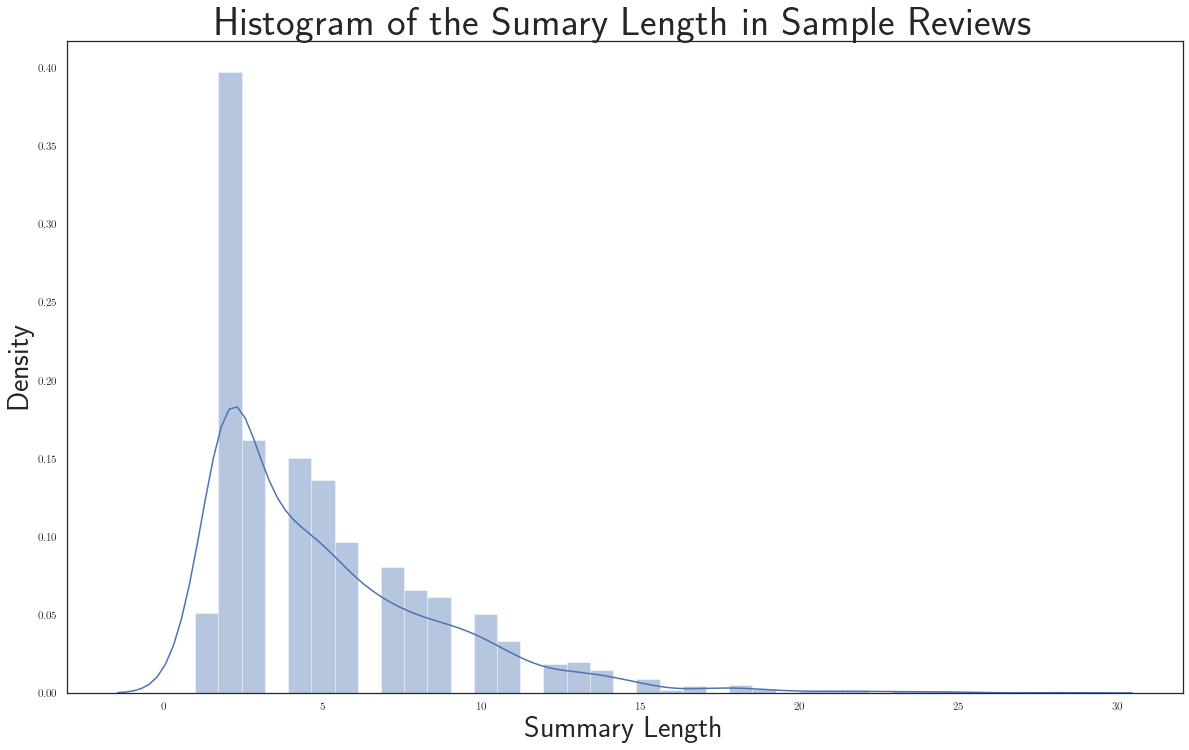

In [820]:
plt.figure(figsize = (20,12))
sns.distplot(df['Summary Length'])
plt.xlabel('Summary Length', fontsize=30)
plt.ylabel('Density', fontsize=30)
plt.title("Histogram of the Sumary Length in Sample Reviews", fontsize=40)
plt.savefig('Plots/SummaryLength.png')

#### Sentiment of Summary

In [821]:
def summary_sentiment(df):
    """
    Outputs the sentiment score for each review summary
    """
    return analyser.polarity_scores(df['summary'])['compound']

df['Summary Sentiment'] = df.apply(summary_sentiment, axis=1)

In [822]:
df['Summary Sentiment'].describe()

count    2567.000000
mean        0.268811
std         0.367739
min        -0.759600
25%         0.000000
50%         0.361200
75%         0.624900
max         0.950100
Name: Summary Sentiment, dtype: float64

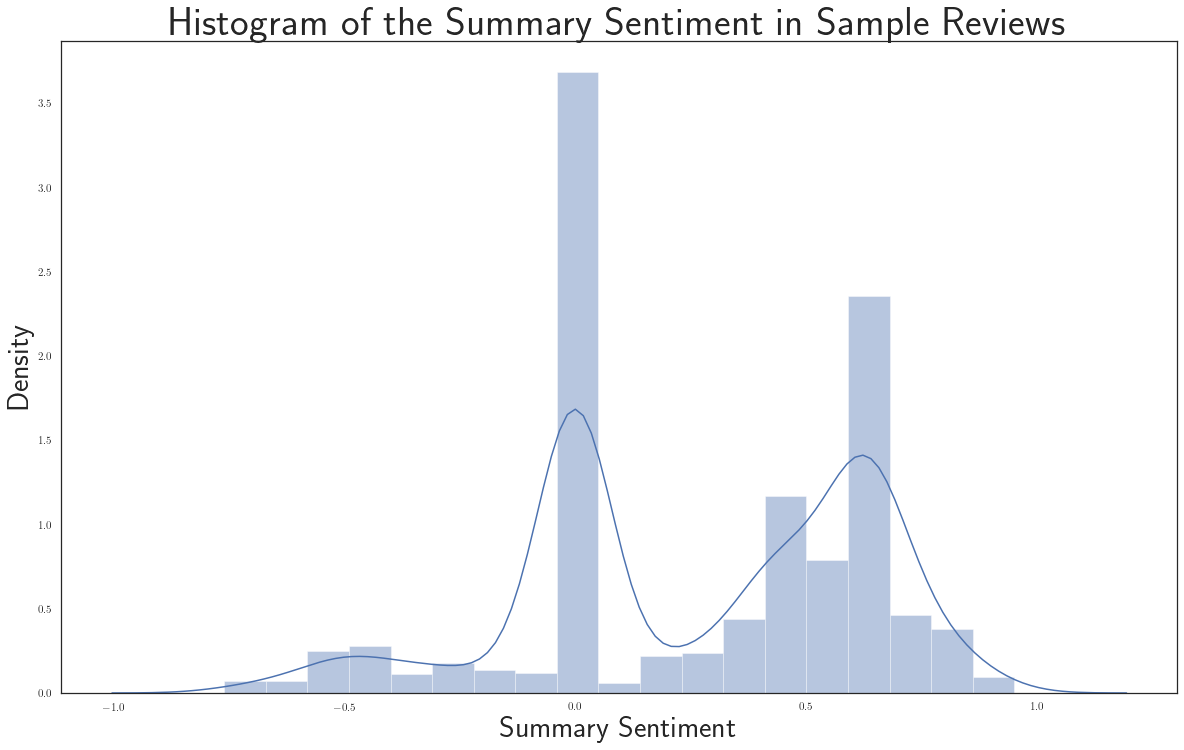

In [823]:
plt.figure(figsize = (20,12))
sns.distplot(df['Summary Sentiment'])
plt.xlabel('Summary Sentiment', fontsize=30)
plt.ylabel('Density', fontsize=30)
plt.title("Histogram of the Summary Sentiment in Sample Reviews", fontsize=40)
plt.savefig('Plots/SummarySentiment.png')

#### Days since the first review

In [824]:
df['unixReviewTime'] = pd.to_datetime(df['unixReviewTime'], unit='s')
df['Days'] = df['unixReviewTime'] - df['unixReviewTime'].min()
df['Days'] = [i.days for i in df['Days']]

#### Before/After verified purchase policy

In [825]:
def verified_option(df):
    """
    Output whether the review was written after the introduction of verified purchase label policy
    """
    if df['unixReviewTime'].date()> datetime(2016, 11, 1).date():
        return 1
    else:
        return 0

df['verified_option'] = df.apply(verified_option, axis=1)
round(100*sum(df['verified_option'])/len(df))

13

#### Styles (Different models)

In [826]:
df['style'].value_counts()

{'Style:': ' Retail'}      1930
{'Style:': ' Business'}     624
Name: style, dtype: int64

In [827]:
# This function is only useful when there are multiple categories in 'style'
def style(df):
    """
    Output the style of the product
    """
    try:
        if 'Size:' in df['style']:
            return yaml.load(df['style'])['Style:']
    except:
        return 0

#df['style'] = df.apply(style, axis=1)
#df['Retail'] = np.where(df['style'] == "{'Style:': ' Retail'}", 1, 0)
#sum(df['Retail'])

#### Rating

In [828]:
# positive reviews
(df['Rating'].value_counts().iloc[0] + df['Rating'].value_counts().iloc[1])/df.shape[0]

0.7892481495909622

In [829]:
# neutral reviews
(df['Rating'].value_counts().iloc[2])/df.shape[0]

0.0802493182703545

In [830]:
# negative reviews
(df['Rating'].value_counts().iloc[3]+df['Rating'].value_counts().iloc[4])/df.shape[0]

0.1305025321386833

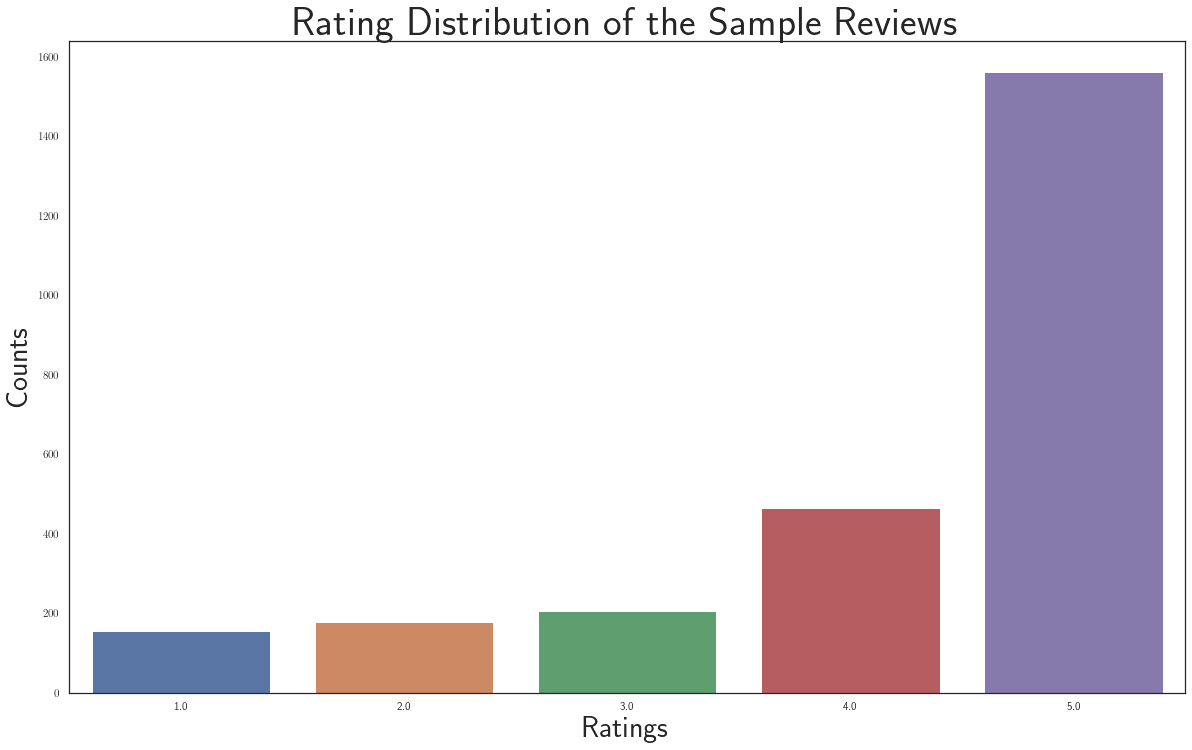

In [831]:
cnt_rating = df['Rating'].value_counts()
plt.figure(figsize=(20,12))
sns.barplot(cnt_rating.index, cnt_rating.values, alpha=1)
plt.ylabel('Counts', fontsize=30)
plt.xlabel('Ratings', fontsize=30)
plt.xticks(rotation=0)
plt.title('Rating Distribution of the Sample Reviews', fontsize=40)
plt.savefig('Plots/Rating Distribution of the Sample Reviews.png')

### Trustworthness Score (y)

#### Convert vote variable to float type

In [832]:
def cleanvote(df):
    """
    Outputs the votes as numerical values 
    """
    try:
        return float(df['vote'])
    except ValueError:
        return float(df['vote'].replace(',', ''))
    
df['vote'] = df.apply(cleanvote, axis=1)

In [833]:
df['vote'].describe()

count     174.000000
mean       16.408046
std        90.983452
min         2.000000
25%         2.000000
50%         3.000000
75%         5.000000
max      1113.000000
Name: vote, dtype: float64

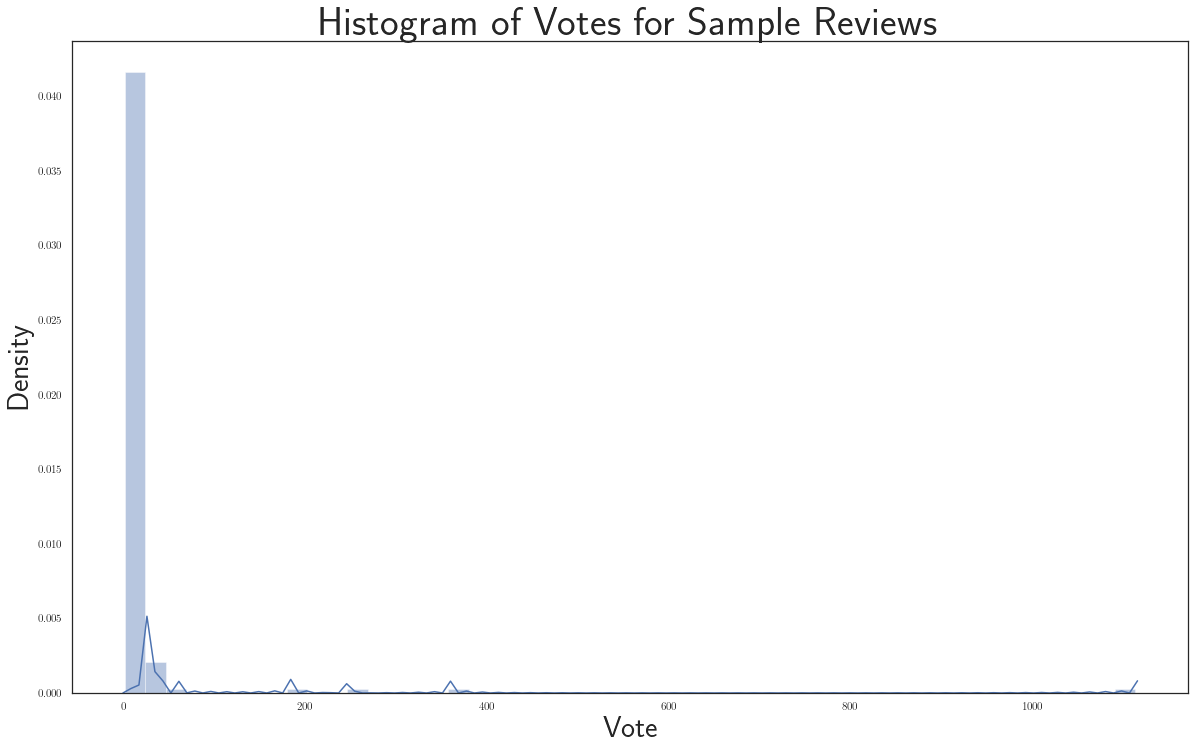

In [834]:
plt.figure(figsize = (20,12))
sns.distplot(df[df['vote'].notnull()]['vote'])
plt.xlabel('Vote', fontsize=30)
plt.ylabel('Density', fontsize=30)
plt.title('Histogram of Votes for Sample Reviews', fontsize=40)
plt.savefig('Plots/Histogram of Votes for Sample Reviews.png')

In [835]:
# % of reviews don't have any votes
df['vote'].isna().sum()/df.shape[0]

0.9322165952473704

In [836]:
df_original[df_original['vote'].isna()]

,Rating,vote,verified,reviewTime,reviewerID,style,reviewerName,reviewText,summary,unixReviewTime,image
3,5.0,NaN,True,"05 15, 2018",A2FMMCFQ8702DN,{'Style:': ' Business'},Wickenball,Love it.,Five Stars,1526342400,NaN
4,5.0,NaN,True,"05 12, 2018",A1I8WBJSZIPJE0,{'Style:': ' Business'},B. Stearn,I've had various versions of this keyboard for...,Five Stars,1526083200,NaN
5,5.0,NaN,True,"05 12, 2018",A1CWLSHHR9KWHL,{'Style:': ' Business'},Roni Me,pefect for me,Five Stars,1526083200,NaN
6,5.0,NaN,True,"05 11, 2018",A3T7XVG3AXJF61,{'Style:': ' Business'},K. Miller,Plugged it in and it works like a champ. Keyb...,Special keys worked out of the box!,1525996800,NaN
7,4.0,NaN,True,"05 5, 2018",AV4PXSFL66YYL,{'Style:': ' Retail'},GEOFFREY B.,Has been installed for over a year and still i...,OK product,1525478400,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2554,2.0,NaN,True,"01 19, 2006",A3EVGPGOFVAP09,{'Style:': ' Retail'},WorknMan,I've been using this model keyboard for over 7...,BEWARE if you're replacing an old one,1137628800,NaN
2563,5.0,NaN,True,"05 19, 2018",A3NOZ4M9D1IIR7,{'Style:': ' Business'},john chamberlain,good,Five Stars,1526688000,NaN
2564,5.0,NaN,True,"05 17, 2018",A36WZAWDM2D487,{'Style:': ' Retail'},Amazon Customer,This is my second time purchasing this keyboar...,The keyboard is dropped on the floor 2 to 3 ti...,1526515200,NaN
2565,5.0,NaN,True,"05 16, 2018",ALZ9C6MTMF20E,{'Style:': ' Business'},D.J.,My favorite keyboard by far. Only issue is tha...,excellent product,1526428800,NaN


#### Position

In [837]:
df['vote2'] = df['vote'] .fillna(0.001)

In [838]:
df['page_index'] = np.ceil((df.index+1)/10)

In [839]:
vote_by_pst = df.groupby(['page_index'])['vote2'].agg({'vote2':['mean']})
vote_by_pst.columns = ['mean']
vote_by_pst.head()

,mean
page_index,
1.0,114.0007
2.0,0.0010
3.0,0.0010
4.0,0.0010
5.0,0.0010


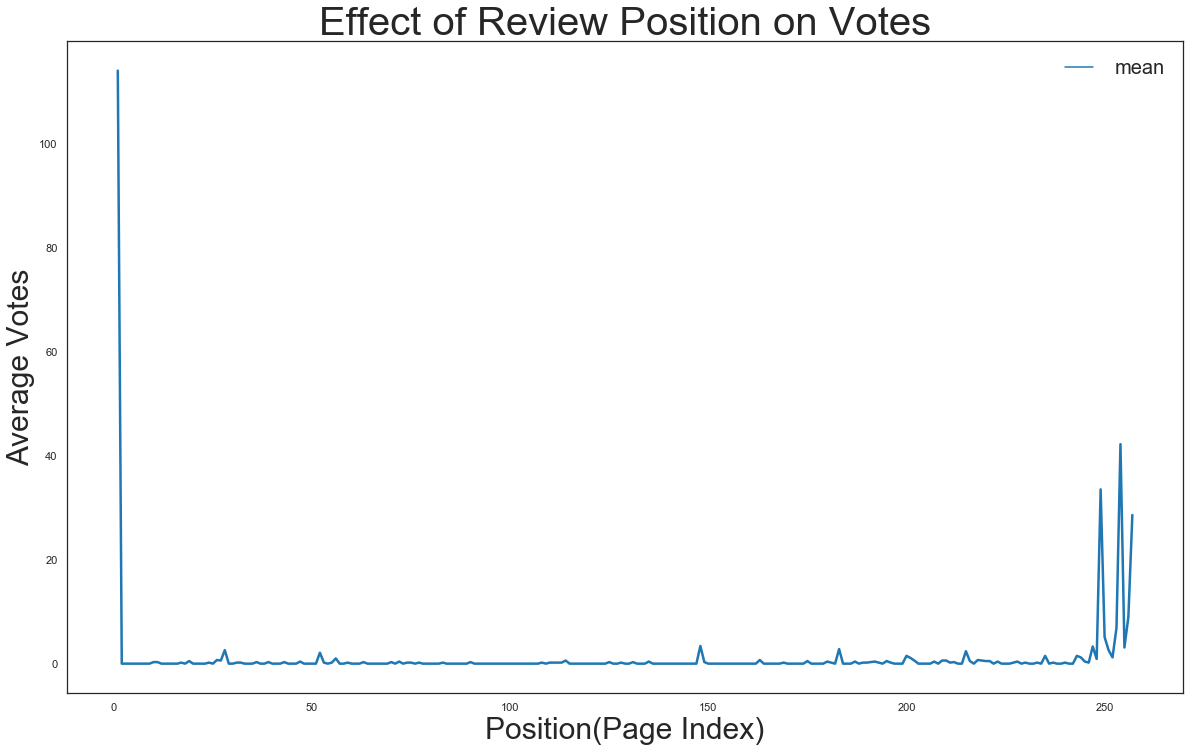

In [998]:
plt.rc('text', usetex=False)
plt.figure(figsize = (20,12))
sns.lineplot(data=vote_by_pst, palette="tab10", linewidth=2.5)
plt.xlabel('Position(Page Index)', fontsize=30)
plt.ylabel('Average Votes', fontsize=30)
plt.legend(numpoints=10, frameon=False, fontsize=20)
plt.title('Effect of Review Position on Votes', fontsize=40)
plt.savefig('Plots/Effect of Review Position on Votes.png')

#### Time

In [841]:
df['Quarters'] = np.ceil(df['Days']/90)

In [842]:
df['Year'] = df['unixReviewTime'].dt.year

In [843]:
vote_by_yr = df.groupby(['Quarters'])['vote2'].agg({'vote2':['mean', 'count']})
vote_by_yr.columns = ['mean', 'count']
#vote_by_yr['rate'] = (vote_by_yr['mean'] - vote_by_yr['mean'].iloc[0])/vote_by_yr['mean'].iloc[0]
vote_by_yr.head(5)

,mean,count
Quarters,,
0.0,11.000000,1
1.0,137.800000,10
2.0,5.384846,13
3.0,6.667000,6
4.0,5.200200,5


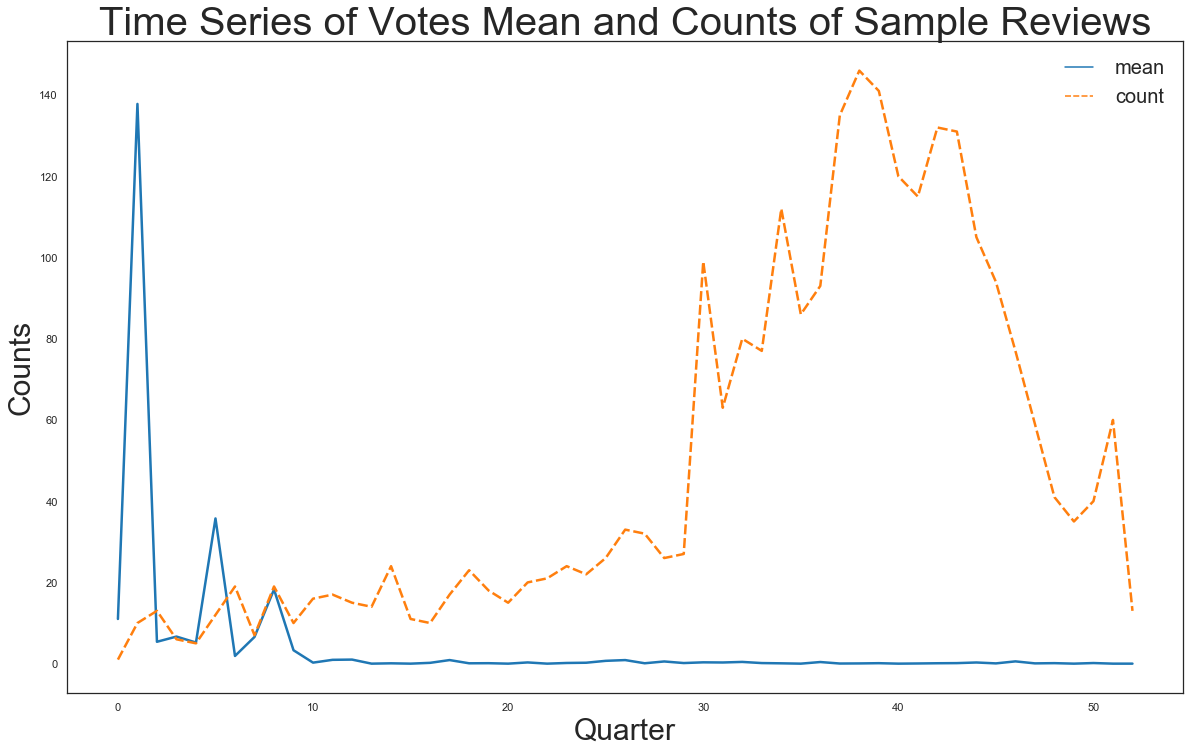

In [999]:
plt.figure(figsize = (20,12))
sns.lineplot(data=vote_by_yr, palette="tab10", linewidth=2.5)
plt.xlabel('Quarter', fontsize=30)
plt.ylabel('Counts', fontsize=30)
plt.legend(numpoints=10, frameon=False, fontsize=20)
plt.title('Time Series of Votes Mean and Counts of Sample Reviews', fontsize=40)
plt.savefig('Plots/Time Series of Votes Mean and Counts of Sample Reviews.png')

#### Correction


Two sources of bias:

1. Time

The reviews range from 2005 to 2018. It is likely older reviews exist in the platform longer and have moe exposures, while the newer reviews are less read by the customers. It is important to re-estimate the actual votes of the reviews by taking the time factor into account.

2. Position

The reviews displayed on top could receive more views and votes.

Model:

$Actual\ vote \propto Current * Quarters * Index $

Intuition: When quarter increases, the votes should increase to compensate for the shorter time of being read. When page index increases, the votes should increase to compensate for the fewer opportuities of being read. 

In [845]:
vote_re = pd.DataFrame({'vote':df['vote2'], 'Quarter':df['Quarters'], 'Index':df['page_index']})
vote_re = pd.DataFrame(scaler.fit_transform(vote_re), columns=['vote','quarter','index'])
vote_re['vote'] = vote_re['vote']+1e-20  # make the votes no-zero so that the correction rates could have an impat
vote_re

,vote,quarter,index
0,1.000000e+00,0.019231,0.0
1,1.437468e-02,0.019231,0.0
2,9.882309e-03,0.000000,0.0
3,1.000000e-20,1.000000,0.0
4,1.000000e-20,1.000000,0.0
...,...,...,...
2562,9.882309e-03,0.019231,1.0
2563,1.000000e-20,1.000000,1.0
2564,1.000000e-20,1.000000,1.0
2565,1.000000e-20,1.000000,1.0


In [846]:
vote_re['score'] = vote_re['vote']*(1+vote_re['quarter']+vote_re['index'])

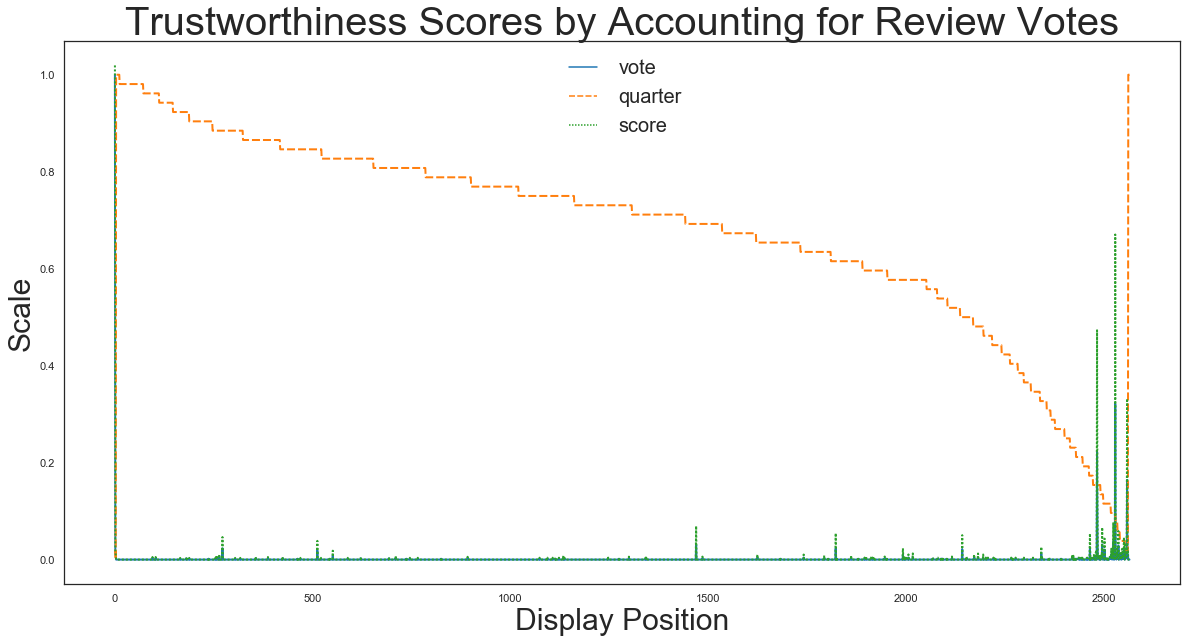

In [847]:
plt.figure(figsize = (20,10))
sns.lineplot(data=vote_re[['vote', 'quarter', 'score']], palette="tab10", linewidth=2)
plt.title('Trustworthiness Scores by Accounting for Review Votes', fontsize=40)
plt.xlabel('Display Position', fontsize=30)
plt.ylabel('Scale', fontsize=30)
plt.legend(numpoints=10, frameon=False, fontsize=20)
plt.savefig('Plots/Trustworthiness Scores by Accounting for Review Votes.png')

In [1001]:
vote_re

,vote,quarter,index,score
0,1.000000e+00,0.019231,0.0,1.019231e+00
1,1.437468e-02,0.019231,0.0,1.465111e-02
2,9.882309e-03,0.000000,0.0,9.882309e-03
3,1.000000e-20,1.000000,0.0,2.000000e-20
4,1.000000e-20,1.000000,0.0,2.000000e-20
...,...,...,...,...
2562,9.882309e-03,0.019231,1.0,1.995466e-02
2563,1.000000e-20,1.000000,1.0,3.000000e-20
2564,1.000000e-20,1.000000,1.0,3.000000e-20
2565,1.000000e-20,1.000000,1.0,3.000000e-20


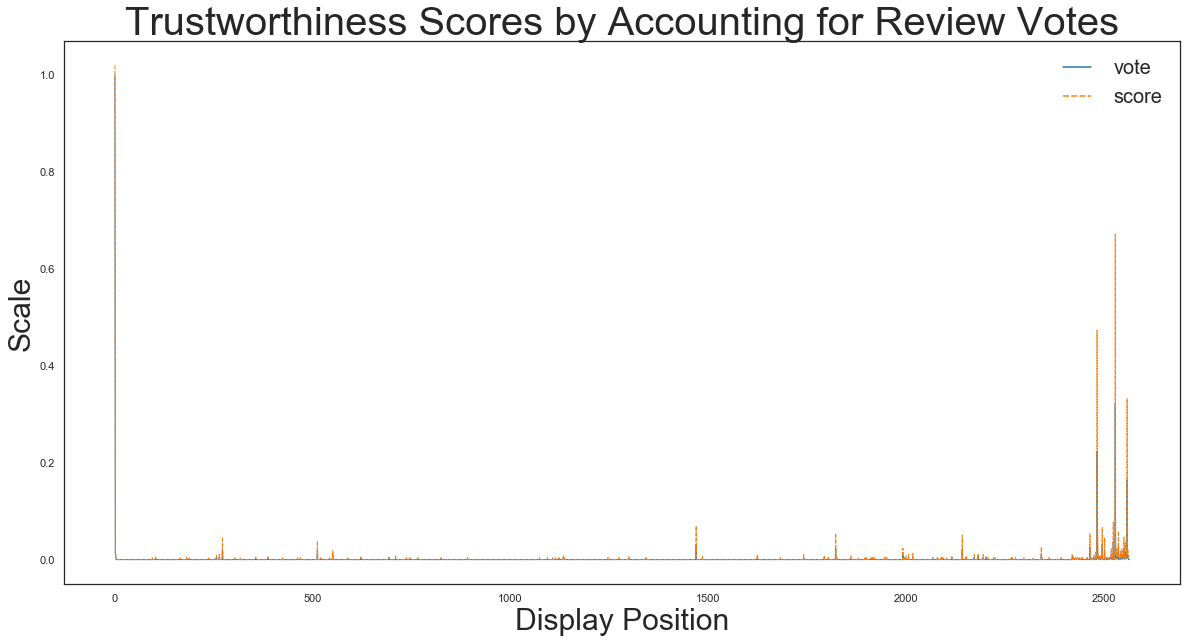

In [1002]:
plt.figure(figsize = (20,10))
sns.lineplot(data=vote_re[['vote', 'score']], palette="tab10", linewidth=1)
plt.title('Trustworthiness Scores by Accounting for Review Votes', fontsize=40)
plt.xlabel('Display Position', fontsize=30)
plt.ylabel('Scale', fontsize=30)
plt.legend(numpoints=10, frameon=False, fontsize=20)

No handles with labels found to put in legend.


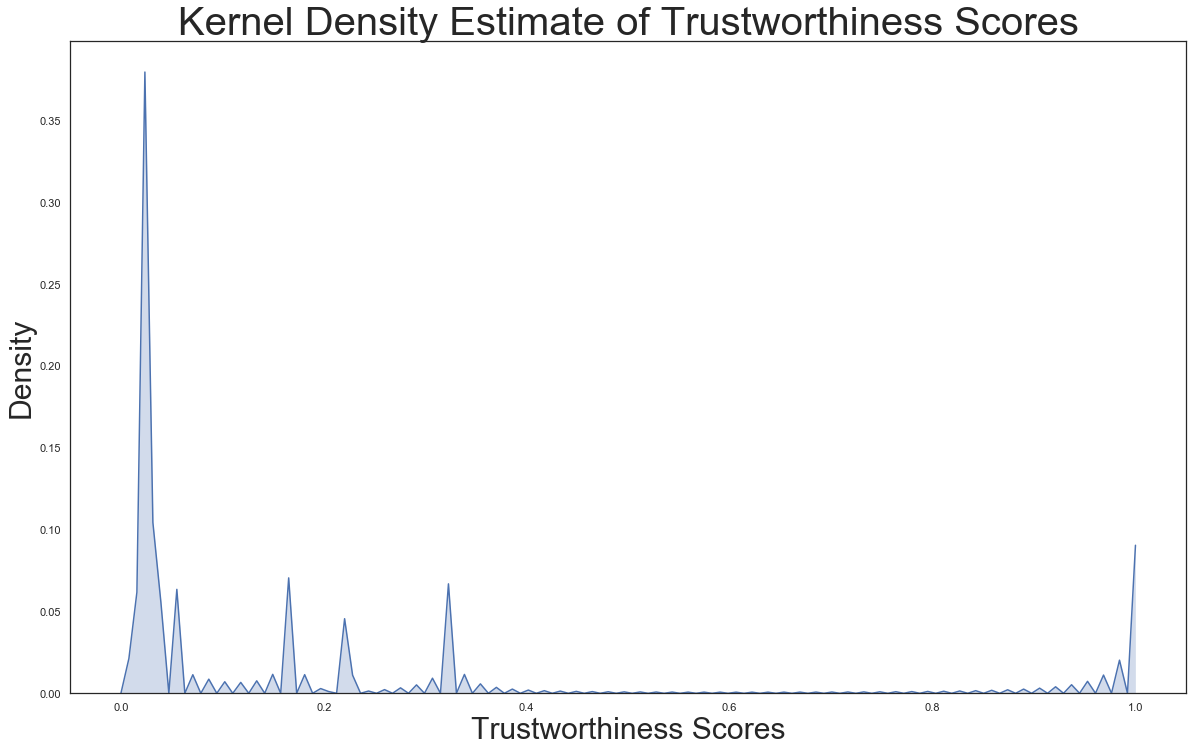

In [1005]:
plt.figure(figsize = (20,12))
sns.distplot(vote_re['vote'], hist=False, color="b", kde_kws={"shade": True})
plt.title('Kernel Density Estimate of Trustworthiness Scores', fontsize=40)
plt.legend(numpoints=10, frameon=False, fontsize=20)
plt.xlabel('Trustworthiness Scores', fontsize=30)
plt.ylabel('Density', fontsize=30)
plt.savefig('Plots/Kernel Density Estimate of Trustworthiness Scores.png')

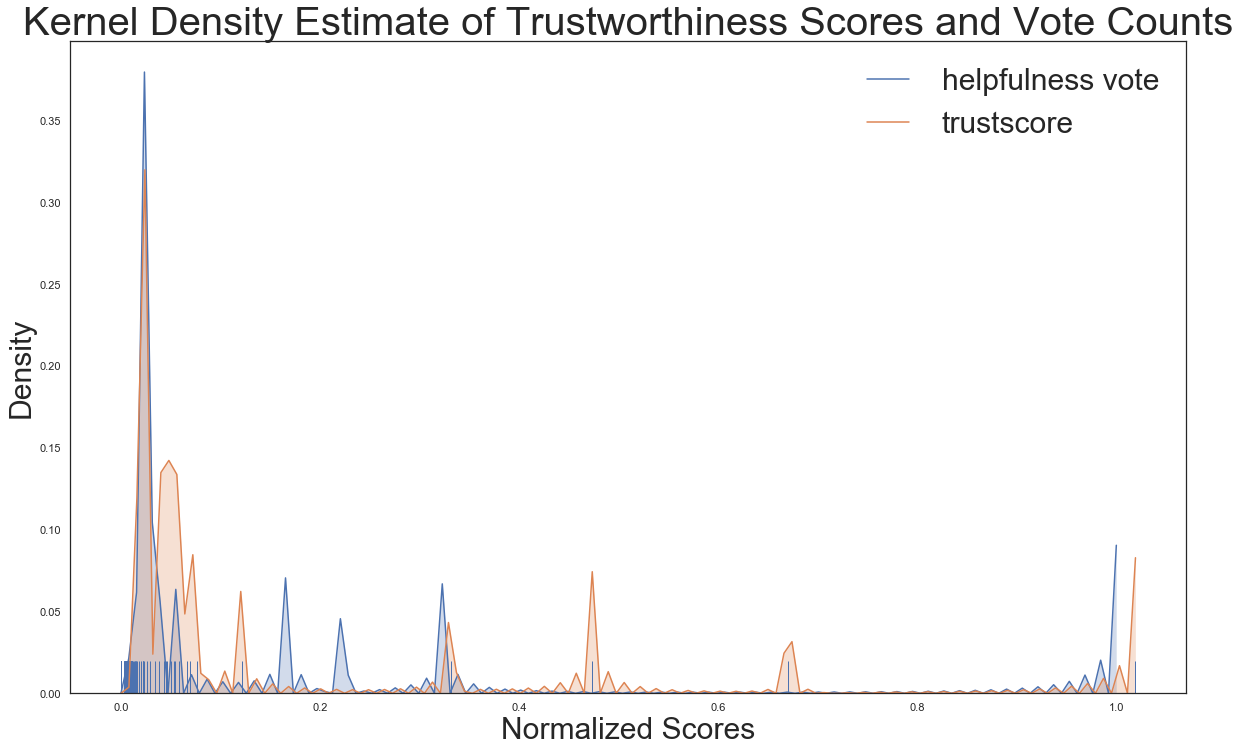

In [1034]:
plt.figure(figsize = (20,12))
plt.title('Kernel Density Estimate of Trustworthiness Scores and Vote Counts', fontsize=40)
sns.kdeplot(vote_re['vote'], label="helpfulness vote", shade=True)
sns.kdeplot(vote_re['score'], label="trustscore", shade=True)
sns.rugplot(vote_re['score'])
plt.legend(numpoints=10, frameon=False, fontsize=30)
plt.xlabel('Normalized Scores', fontsize=30)
plt.ylabel('Density', fontsize=30)
plt.savefig('Plots/Kernel Density Estimate of Trustworthiness Scores and Vote Counts.png')

In [849]:
df['score'] = vote_re['score'].rank()

### Exploratory Data Analysis 

#### Select features by theory

In [850]:
df.columns

Index(['Rating', 'vote', 'verified', 'reviewTime', 'reviewerID', 'style',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'image',
       'Topic1', 'Topic2', 'Topic3', 'Topic4', 'Image Number',
       'Verified Purchase', 'Verified Name', 'Sentiment', 'Review Length',
       'Digits Count', 'Readability Score', 'Summary Length',
       'Summary Sentiment', 'Days', 'verified_option', 'vote2', 'page_index',
       'Quarters', 'Year', 'score'],
      dtype='object')

In [851]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2567 entries, 0 to 2566
Data columns (total 31 columns):
Rating               2567 non-null float64
vote                 174 non-null float64
verified             2567 non-null bool
reviewTime           2567 non-null object
reviewerID           2567 non-null object
style                2554 non-null object
reviewerName         2567 non-null object
reviewText           2567 non-null object
summary              2567 non-null object
unixReviewTime       2567 non-null datetime64[ns]
image                13 non-null object
Topic1               2567 non-null float64
Topic2               2567 non-null float64
Topic3               2567 non-null float64
Topic4               2567 non-null float64
Image Number         2567 non-null int64
Verified Purchase    2567 non-null int64
Verified Name        2567 non-null float64
Sentiment            2567 non-null float64
Review Length        2567 non-null int64
Digits Count         2567 non-null int64
Read

In [852]:
features = ['Rating', 'Image Number', 'Verified Name', 'Verified Purchase',         # objective reviewers' info
            'Sentiment', 'Review Length', 'Digits Count', 'Readability Score',      # characteristics of reviews
            'Summary Length', 'Summary Sentiment']                                  # characteristics of reviews summary

features = features+topic_names                                                    # add topics 

#### Summary statistics

In [853]:
df.drop(['style', 'reviewerID', 'reviewerName', 
         'image', 'reviewTime',], axis=1, inplace=True)

In [854]:
df.columns

Index(['Rating', 'vote', 'verified', 'reviewText', 'summary', 'unixReviewTime',
       'Topic1', 'Topic2', 'Topic3', 'Topic4', 'Image Number',
       'Verified Purchase', 'Verified Name', 'Sentiment', 'Review Length',
       'Digits Count', 'Readability Score', 'Summary Length',
       'Summary Sentiment', 'Days', 'verified_option', 'vote2', 'page_index',
       'Quarters', 'Year', 'score'],
      dtype='object')

In [855]:
summary_stat = df[features].describe().round(2)

In [856]:
summary_stat = summary_stat.T

In [857]:
summary_stat.drop(['count'], axis=1, inplace=True)

In [858]:
summary_stat

,mean,std,min,25%,50%,75%,max
Rating,4.21,1.21,1.00,4.00,5.00,5.00,5.00
Image Number,0.55,9.56,0.00,0.00,0.00,0.00,370.00
Verified Name,0.32,0.47,0.00,0.00,0.00,1.00,1.00
Verified Purchase,0.86,0.34,0.00,1.00,1.00,1.00,1.00
Sentiment,0.45,0.54,-0.99,0.14,0.64,0.88,1.00
Review Length,81.37,103.03,0.00,20.00,49.00,102.00,1179.00
Digits Count,0.46,1.01,0.00,0.00,0.00,1.00,13.00
Readability Score,54.32,65.76,-1108.30,46.44,71.48,83.66,206.84
Summary Length,5.08,3.70,1.00,2.00,4.00,7.00,28.00
Summary Sentiment,0.27,0.37,-0.76,0.00,0.36,0.62,0.95


In [888]:
with open('summary_table.tex','w') as tf:
    tf.write(summary_stat.to_latex())

#### Correlation

In [860]:
df[features].corr()<0.5

,Rating,Image Number,Verified Name,Verified Purchase,Sentiment,Review Length,Digits Count,Readability Score,Summary Length,Summary Sentiment,Topic1,Topic2,Topic3,Topic4
Rating,False,True,True,True,True,True,True,True,True,True,True,True,True,True
Image Number,True,False,True,True,True,True,True,True,True,True,True,True,True,True
Verified Name,True,True,False,True,True,True,True,True,True,True,True,True,True,True
Verified Purchase,True,True,True,False,True,True,True,True,True,True,True,True,True,True
Sentiment,True,True,True,True,False,True,True,True,True,True,True,True,True,True
Review Length,True,True,True,True,True,False,True,True,True,True,True,True,True,True
Digits Count,True,True,True,True,True,True,False,True,True,True,True,True,True,True
Readability Score,True,True,True,True,True,True,True,False,True,True,True,True,True,True
Summary Length,True,True,True,True,True,True,True,True,False,True,True,True,True,True
Summary Sentiment,True,True,True,True,True,True,True,True,True,False,True,True,True,True


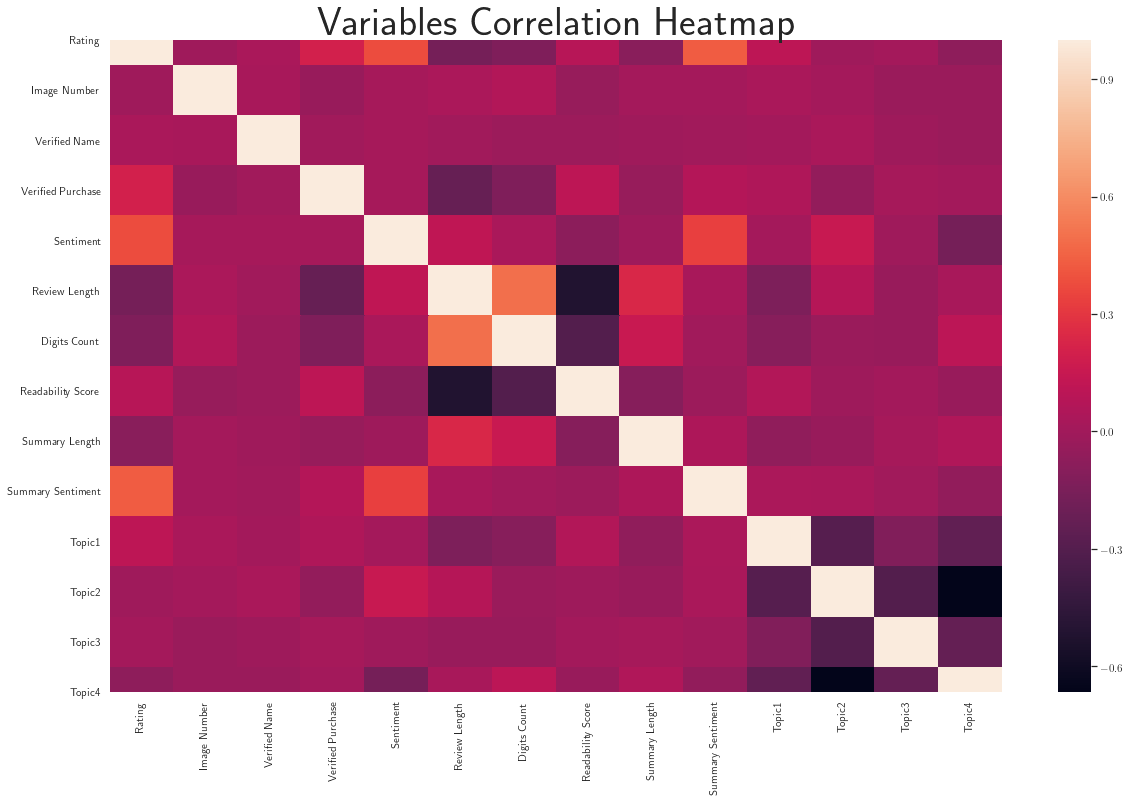

In [890]:
plt.figure(figsize=(20,12))
sns.heatmap(df[features].corr(), annot=False)
plt.title("Variables Correlation Heatmap", fontsize=40)
plt.savefig('Plots/Variables Correlation Heatmap.png')

### Export data

In [862]:
df[features]

,Rating,Image Number,Verified Name,Verified Purchase,Sentiment,Review Length,Digits Count,Readability Score,Summary Length,Summary Sentiment,Topic1,Topic2,Topic3,Topic4
0,5.0,0,1.0,1,0.9981,780,1,-703.31,5,0.6369,0.103297,0.427077,0.110508,0.359117
1,5.0,0,0.0,1,0.8232,267,0,-182.62,4,0.6369,0.124406,0.422721,0.109800,0.343073
2,4.0,0,0.0,1,0.9947,917,0,34.84,4,0.2500,0.097913,0.456287,0.105561,0.340239
3,5.0,0,0.0,1,0.6369,2,0,120.21,2,0.0000,0.112453,0.425718,0.112541,0.349288
4,5.0,0,0.0,1,0.4753,16,0,80.62,2,0.0000,0.109095,0.422178,0.111601,0.357126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2562,1.0,0,0.0,0,0.9287,213,3,42.76,10,-0.4767,0.104667,0.432303,0.112332,0.350698
2563,5.0,0,0.0,1,0.4404,1,0,121.22,2,0.0000,0.102864,0.425246,0.112541,0.359349
2564,5.0,0,0.0,1,0.4325,82,3,67.59,28,0.8795,0.105884,0.432735,0.113486,0.347896
2565,5.0,0,0.0,1,0.2500,32,0,80.62,2,0.5719,0.106338,0.427437,0.110270,0.355956


In [863]:
subdf = df[features]
subdf['score'] = df['score']
subdf.to_csv('keyboard_data.csv', index = False)

### Model

In [864]:
df = pd.read_csv('keyboard_data.csv')

#### Model Class

In [865]:
df.columns

Index(['Rating', 'Image Number', 'Verified Name', 'Verified Purchase',
       'Sentiment', 'Review Length', 'Digits Count', 'Readability Score',
       'Summary Length', 'Summary Sentiment', 'Topic1', 'Topic2', 'Topic3',
       'Topic4', 'score'],
      dtype='object')

In [866]:
def render_table(data, col_width = 3.0, row_height = 0.625, font_size = 14,
                     header_color = '#40466e', row_colors = ['#f1f1f2', 'w'], edge_color = 'w',
                     bbox = [0, 0, 1, 1], header_columns = 0, ax = None, **kwargs):
    
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText = data.values, bbox = bbox, colLabels = data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight = 'bold', color = 'w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

In [867]:
df[features]

,Rating,Image Number,Verified Name,Verified Purchase,Sentiment,Review Length,Digits Count,Readability Score,Summary Length,Summary Sentiment,Topic1,Topic2,Topic3,Topic4
0,5.0,0,1.0,1,0.9981,780,1,-703.31,5,0.6369,0.103297,0.427077,0.110508,0.359117
1,5.0,0,0.0,1,0.8232,267,0,-182.62,4,0.6369,0.124406,0.422721,0.109800,0.343073
2,4.0,0,0.0,1,0.9947,917,0,34.84,4,0.2500,0.097913,0.456287,0.105561,0.340239
3,5.0,0,0.0,1,0.6369,2,0,120.21,2,0.0000,0.112453,0.425718,0.112541,0.349288
4,5.0,0,0.0,1,0.4753,16,0,80.62,2,0.0000,0.109095,0.422178,0.111601,0.357126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2562,1.0,0,0.0,0,0.9287,213,3,42.76,10,-0.4767,0.104667,0.432303,0.112332,0.350698
2563,5.0,0,0.0,1,0.4404,1,0,121.22,2,0.0000,0.102864,0.425246,0.112541,0.359349
2564,5.0,0,0.0,1,0.4325,82,3,67.59,28,0.8795,0.105884,0.432735,0.113486,0.347896
2565,5.0,0,0.0,1,0.2500,32,0,80.62,2,0.5719,0.106338,0.427437,0.110270,0.355956


In [1074]:
class features_selection:
    '''
    This class takes the cleaned review data and apply three ways (random forest, linear regression, lasso regression) for selecting predictive features.
    '''
    def __init__(self, df, rating):
        
        self.rating = rating
        self.df = df
        self.out = pd.DataFrame()
        plt.rc('text', usetex = False)

 
    def data_preprocessing(self):
        if self.rating == 'all':
            self.df = df
        elif self.rating == 'pos':
            self.df = df[df['Rating']>3]
        elif self.rating == 'neg':
            self.df = df[df['Rating']<3]
        elif self.rating == 'neu':
            self.df = df[df['Rating']==3]
        else:
            print('wrong input')
         
                
        # Select features that capture information that customers would see when reading reviews
        self.X = self.df[features]
        self.y = self.df['score']
        
        #print(self.X.shape, self.y.shape)
        
        # Divide the data into training and test set, with ratio 3:1 (test=20%).
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, random_state = 0)
        # Standarization
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_test = scaler.fit_transform(self.X_test)
        
        self.out["Variables"] = self.X.columns
        
    def label(self):
        '''
        Return full name for plotting graphs
        '''
        if self.rating == 'all':
            return "for All Reviews in the Sample"
        elif self.rating == 'pos':
            return "for Positive Reviews in the Sample"
        elif self.rating == 'neg':
            return "for Negative Reviews in the Sample"
        elif self.rating == 'neu':
            return "for Neutral Reviews in the Sample"
        else:
            return None
        
    def random_forest(self):
        '''
        Feature importance using Random Forest
        '''
        self.data_preprocessing()
        rfr = RandomForestRegressor(n_estimators = 100, n_jobs = 4).fit(self.X_train, self.y_train)
        imp = pd.DataFrame({"Variables": self.X.columns, "rfr_select": rfr.feature_importances_})
        imp = imp.sort_values(by='rfr_select', ascending=False)
        imp = imp.round(2)
        
        render_table(imp)
        #plt.figure(figsize = (10,6))
        rfr_title = "Random Forest Feature Importance Results " + self.label()
        plt.title(rfr_title, fontsize=40)
        #plt.savefig("Plots/"+rfr_title)
        plt.close()
        
        self.out['rfr_score'] = rfr.feature_importances_
        self.out['random_forest_imp'] = np.where(rankdata(rfr.feature_importances_)>10, 1, 0)
        
        plt.figure(figsize = (24,16))
        plt.hlines(y = imp["Variables"], xmin = 0, xmax = imp['rfr_select'],
           linestyles = 'dashed', color = 'maroon')

        plt.plot(imp['rfr_select'], imp["Variables"], ">", color = 'maroon')

        plt.yticks(imp["Variables"], fontsize=20)
        title = "Random Forest Variable Importance Plot" + self.label()
        plt.title(title, loc = 'center', fontsize=40)
        plt.xlabel('scores', fontsize=30)
        plt.savefig("Plots/"+title + '.png')
        plt.close()
        
        
        
    def linear(self):
        '''
        Fit the linear model with Ordinary Least Square
        '''
        self.data_preprocessing()
        lin = LinearRegression().fit(self.X_train, self.y_train)
        linkf = cross_val_score(lin, self.X_train, self.y_train, cv=5, scoring="neg_mean_squared_error")
        #print("Mean:",round(-linkf.mean(),2))
        #print("Standard deviation:",round(linkf.std(),2))
        
        self.X2 = sm.add_constant(self.X_train)
        model = sm.OLS(self.y_train, self.X2).fit()
        #predictions = model.predict(X) 
        print_model = model.summary()
        #print(print_model)
        
        Xcols = [i for i in self.X.columns]
        Xcols.insert(0, 'Intercept')
        self.reg = pd.DataFrame({'Index':Xcols, 
                                 'Coefficients':model.params, 
                                 'Std': model.bse, 
                                 'p_value':model.pvalues,
                                 'Significant at 95% level':np.where(model.pvalues<0.05,1,0)}).round(0)
        self.reg.set_index('Index', inplace=True)
        #self.reg.index.name = None
        
        self.out['linear_coef'] = [int(round(i,0)) for i in model.params[1:]]
        self.out['linear_imp'] = np.where(model.pvalues[1:]<0.05,1,0)
        
        render_table(self.reg)
        linear_title = "Linear Regression Results " + self.label()
        plt.title(linear_title, fontsize=40)
        plt.savefig("Plots/"+linear_title)
        plt.close()
        
        with open(linear_title+'.tex','w') as tf:
            tf.write(self.reg.to_latex())
        
        #return [(Xcols[i], model.params[i].round(2))  for i in range(len(Xcols)) if np.where(model.pvalues<0.05,1,0)[i]==1]
    
        
    def lasso(self):
        '''
        Fit the lasso model
        '''
        self.data_preprocessing()
        las = Lasso().fit(self.X_train, self.y_train)
        self.alpha_grid = {"alpha": np.linspace(0,10,50)}
        self.grid_search_las = GridSearchCV(las, param_grid = self.alpha_grid, n_jobs = 4, cv = 5,
                               scoring='neg_mean_squared_error').fit(self.X_train, self.y_train)

        #print('GridBestEstimatorLasso=', grid_search_las.best_estimator_)
        #print('GridBestParamsLasso=', grid_search_las.best_params_)
        #print('GridBestScoreLasso=', -grid_search_las.best_score_)
        
        las = Lasso(alpha = self.grid_search_las.best_params_['alpha']).fit(self.X_train, self.y_train)
        laskf = cross_val_score(las, self.X_train, self.y_train, cv = 5, 
                              scoring="neg_mean_squared_error")
        #print("Mean:", round(-laskf.mean(),2))
        #print("Standard deviation:",round(laskf.std(),2))
        lasso_output = pd.DataFrame({"Variables": self.X.columns, "Coefficients": las.coef_}).round(0)
        
        self.out['lasso_coef'] = [int(round(i,0)) for i in las.coef_]
        self.out['lasso_imp'] = np.where(rankdata(np.abs(las.coef_))>10, 1, 0)
        
        render_table(lasso_output)
        lasso_title = "Lasso Regression Results " + self.label()
        plt.title(lasso_title, fontsize=40)
        #plt.savefig("Plots/"+lasso_title)
        plt.close()
        
        ## print lasso path
        ### https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.lasso_path.html
        
        self.nrows, self.ncols = self.X.shape

        eps = 5e-8  # the smaller it is the longer is the path eps = alpha_min / alpha_max = 1e-3

        self.alphas_lasso, self.coefs_lasso, _ = linear_model.lasso_path(self.X_train, self.y_train, eps, fit_intercept=True)

        # Display results
        plt.figure(figsize = (24,16))
        #neg_log_alphas_lasso = -np.log10(alphas_lasso)

        for i in range(self.ncols):
            plt.plot(self.alphas_lasso, self.coefs_lasso[i], label = [i for i in self.X.columns][i])

        plt.xscale('log')
        plt.xlabel('Log($\\lambda$)', fontsize=30)
        plt.ylabel('coefficients', fontsize=30)
        path_title = "Lasso Path at Different Lambda " + self.label()
        plt.title(path_title, fontsize=40)
        plt.legend(numpoints=10, frameon=False, fontsize=20)
        plt.axis('tight')  
        plt.savefig("Plots/"+path_title + '.png')
        plt.close()
        
    def output(self):
        self.random_forest()
        self.linear()
        self.lasso()
        self.out['aggregated_results'] = self.out['random_forest_imp']+self.out['linear_imp']+self.out['lasso_imp']
        self.out = self.out.sort_values(by='aggregated_results', ascending=False).round(2)
        
        self.out.set_index('Variables', inplace=True)
        self.out.index.name = None
        
        # correlation (which method correlates most with the majority vote)
        rfr_corr = np.corrcoef(self.out['aggregated_results'], self.out['random_forest_imp'])[0,1].round(2)
        linear_corr = np.corrcoef(self.out['aggregated_results'], self.out['linear_imp'])[0,1].round(2)
        lasso_corr = np.corrcoef(self.out['aggregated_results'], self.out['lasso_imp'])[0,1].round(2)
        print("Random Forest:", rfr_corr, "Linear:", linear_corr, "Lasso:", lasso_corr)
        
        render_table(self.out)
        output_title = "Ensemble Variable Importance Results " + self.label()
        plt.title(output_title, fontsize=20)
        plt.savefig("Plots/"+output_title)
        plt.close()
        
        with open(output_title+'.tex','w') as tf:
             tf.write(self.out[['random_forest_imp', 'linear_imp', 'lasso_imp', 'aggregated_results']].to_latex())
        
    
        return self.out
                              


#### Full data

In [1075]:
df_full = features_selection(df, 'all')
df_full.output()

Random Forest: 0.41 Linear: 0.89 Lasso: 0.89


,rfr_score,random_forest_imp,linear_coef,linear_imp,lasso_coef,lasso_imp,aggregated_results
Review Length,0.26,1,2298,1,2106,1,3
Rating,0.02,0,-287,1,-247,1,2
Summary Length,0.08,0,-546,1,-332,1,2
Summary Sentiment,0.06,0,258,1,182,1,2
Topic1,0.09,1,8813402,0,-110,0,1
Topic2,0.09,1,17008831,0,0,0,1
Topic4,0.10,1,15725887,0,0,0,1
Image Number,0.00,0,-224,0,0,0,0
Verified Name,0.01,0,-7,0,0,0,0
Verified Purchase,0.01,0,-63,0,-69,0,0


#### Subset: Positive Reviews

In [986]:
df_positive = features_selection(df, 'pos')
df_positive = df_positive.output()

Random Forest: 0.44 Linear: 0.79 Lasso: 0.79


,rfr_score,random_forest_imp,linear_coef,linear_imp,lasso_coef,lasso_imp,aggregated_results
Review Length,0.27,1,1784,1,1765,1,3
Readability Score,0.09,0,-664,1,-474,1,2
Summary Length,0.08,0,-561,1,-475,1,2
Rating,0.01,0,-100,1,-97,0,1
Digits Count,0.02,0,329,0,258,1,1
Topic1,0.09,1,16922926,0,-39,0,1
Topic3,0.09,1,18675299,0,0,0,1
Topic4,0.10,1,26731018,0,0,0,1
Image Number,0.00,0,309,0,0,0,0
Verified Name,0.01,0,16,0,11,0,0


#### Subset: Negative Reviews

In [994]:
df_negative = features_selection(df, 'neg')
df_negative = df_negative.output()

Random Forest: 0.44 Linear: 0.79 Lasso: 0.79


,rfr_score,random_forest_imp,linear_coef,linear_imp,lasso_coef,lasso_imp,aggregated_results
Review Length,0.26,1,1414,1,1035,1,3
Image Number,0.00,0,1283,1,605,1,2
Summary Sentiment,0.06,0,522,1,401,1,2
Verified Purchase,0.02,0,-237,1,-223,0,1
Readability Score,0.07,0,-650,0,-424,1,1
Topic1,0.09,1,-21508907,0,0,0,1
Topic2,0.12,1,-41930426,0,0,0,1
Topic3,0.11,1,-22566348,0,0,0,1
Rating,0.02,0,-80,0,-53,0,0
Verified Name,0.01,0,-41,0,0,0,0


#### Subset: Neutral Reviews

In [991]:
df_neutral = features_selection(df, 'neu')
df_neutral = df_neutral.output()

Random Forest: 0.65 Linear: 0.86 Lasso: 0.65


,rfr_score,random_forest_imp,linear_coef,linear_imp,lasso_coef,lasso_imp,aggregated_results
Review Length,0.27,1,1403,1,959,1,3
Sentiment,0.10,1,-396,1,-143,0,2
Summary Length,0.08,0,-811,1,-270,1,2
Verified Purchase,0.01,0,-235,0,-211,1,1
Summary Sentiment,0.06,0,550,0,224,1,1
Topic2,0.11,1,104428831,0,0,0,1
Topic4,0.14,1,80251296,0,115,0,1
Rating,0.00,0,0,0,0,0,0
Image Number,0.00,0,0,0,0,0,0
Verified Name,0.00,0,101,0,9,0,0


#### Aggregate barchart

In [873]:
n_features = len(features)
df_positive['group'] = ["positive"] * n_features
df_neutral['group'] = ["neutral"] * n_features
df_negative['group'] = ["negative"] * n_features
df_agg = pd.concat([df_positive, df_neutral, df_negative], axis=0)
df_agg['features'] = df_agg.index
df_agg_grouped = df_agg.groupby('features')['aggregated_results'].sum()
df_agg = df_agg.merge(df_agg_grouped, on='features')
df_agg = df_agg.rename(columns={'aggregated_results_x': 'importance votes'})
df_agg.sort_values(by='importance votes', ascending=False, inplace=True)

In [874]:
df_agg.head()

,features,rfr_select,rfr_imp,linear_select,linear_imp,lasso_select,lasso_imp,importance votes,group,imp_agg_y
0,Review Length,0.27,1,1783.81,1,1765.03,1,3,positive,9
2,Review Length,0.26,1,1414.45,1,1035.13,1,3,negative,9
1,Review Length,0.25,1,1402.63,1,959.05,1,3,neutral,9
26,Image Number,0.00,0,1283.14,1,604.72,1,2,negative,2
3,Readability Score,0.08,0,-664.42,1,-473.61,1,2,positive,3


In [875]:
df_agg['features'].unique()

array(['Review Length', 'Image Number', 'Readability Score',
       'Summary Sentiment', 'Summary Length', 'Sentiment', 'Topic3',
       'Topic4', 'Verified Purchase', 'Topic1', 'Topic2', 'Digits Count',
       'Rating', 'Verified Name'], dtype=object)

<Figure size 1800x432 with 0 Axes>

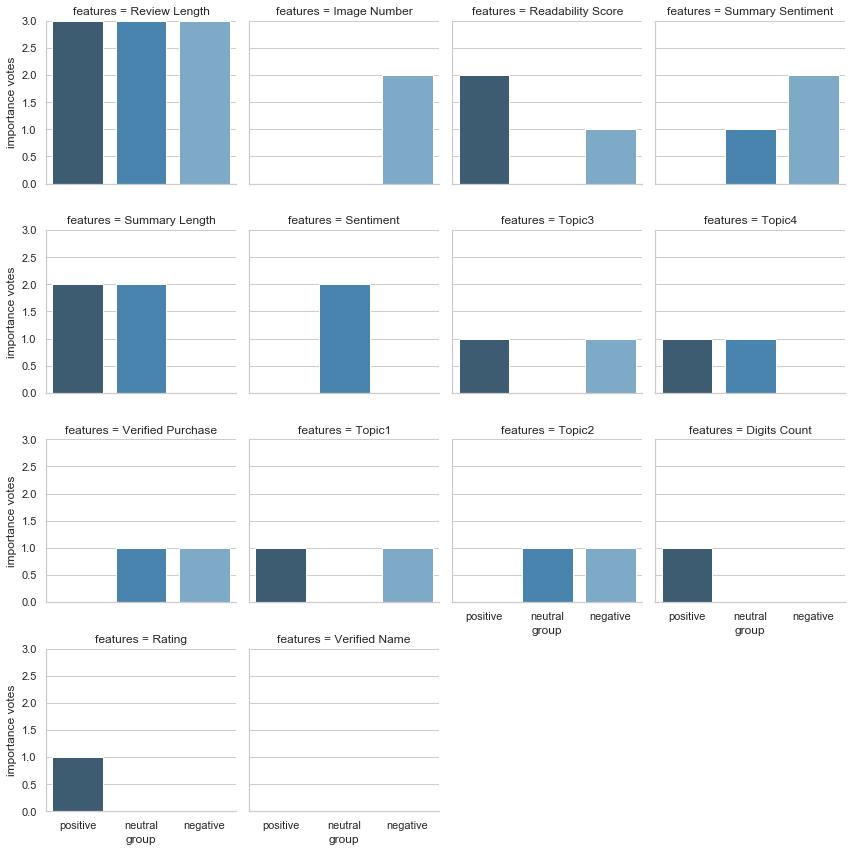

In [876]:
sns.set(style="whitegrid")
plt.figure(figsize = (25,6))
g = sns.FacetGrid(df_agg, col="features",  col_wrap=4, size=3, ylim=(0, 3))
g.map(sns.barplot, "group", "importance votes", color=".9", 
      palette='Blues_d', order = ["positive", "neutral", "negative"])
    
plt.savefig("Plots/Importance Votes of Variables at Positive, Neutral, and Negative Reviews.png")

In [877]:
## Running time
end = time.time()
(end - start)/60

26479939.591435783

In [878]:
time.gmtime(end - start)

time.struct_time(tm_year=2020, tm_mon=5, tm_mday=6, tm_hour=20, tm_min=19, tm_sec=35, tm_wday=2, tm_yday=127, tm_isdst=0)